# Name: Kriti Shukla

In [1]:
import warnings
warnings.filterwarnings("ignore")

import math
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_curve, auc, f1_score, accuracy_score
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn import svm

### 1.(a) Download the APS Failure data from: https://archive.ics.uci.edu/ml/datasets/APS+Failure+at+Scania+Trucks . The dataset contains a training set and a test set. The training set contains 60,000 rows, of which 1,000 belong to the positive class and 171 columns, of which one is the class column. All attributes are numeric.

In [2]:
filepath_train = '../data/aps_failure_training_set.csv'
filepath_test = '../data/aps_failure_test_set.csv'

df_train_const = pd.read_csv(filepath_train, skiprows=20, na_values = 'na')
df_test_const = pd.read_csv(filepath_test, skiprows=20, na_values = 'na')
df_all_const = pd.concat([df_train_const,df_test_const],ignore_index=True)

df_train = pd.read_csv(filepath_train, skiprows=20)
df_test = pd.read_csv(filepath_test, skiprows=20)
df_all = pd.concat([df_train,df_test],ignore_index=True)

print("df_train: ", df_train)
print("df_test: ", df_test)

df_train:        class  aa_000 ab_000      ac_000 ad_000 ae_000 af_000 ag_000 ag_001  \
0       neg   76698     na  2130706438    280      0      0      0      0   
1       neg   33058     na           0     na      0      0      0      0   
2       neg   41040     na         228    100      0      0      0      0   
3       neg      12      0          70     66      0     10      0      0   
4       neg   60874     na        1368    458      0      0      0      0   
...     ...     ...    ...         ...    ...    ...    ...    ...    ...   
59995   neg  153002     na         664    186      0      0      0      0   
59996   neg    2286     na  2130706538    224      0      0      0      0   
59997   neg     112      0  2130706432     18      0      0      0      0   
59998   neg   80292     na  2130706432    494      0      0      0      0   
59999   neg   40222     na         698    628      0      0      0      0   

      ag_002  ...   ee_002  ee_003   ee_004   ee_005   ee_006  e

### (b) Data Preparation

### This data set has missing values. When the number of data with missing values is significant, discarding them is not a good idea.

### i. Research what types of techniques are usually used for dealing with data with missing values. Pick at least one of them and apply it to this data in the next steps.

#### Some techniques used:
    
- Fill out missing values using mean, median, mode etc values.

- Replace the missing values with a randomly chosen value from within the dataset

- Expectation Maximization


I pick the first option, replacing the missing values with the mean.

In [22]:
df_train = df_train.replace('na',np.nan)
df_test = df_test.replace('na',np.nan)
df_all = df_all.replace('na',np.nan)

df_train_y = df_train.loc[:, ['class']]
df_train_x = df_train.drop(columns=['class'])
df_test_y = df_test.loc[:, ['class']]
df_test_x = df_test.drop(columns=['class'])
df_all_x = df_all.drop(columns=['class'])
df_all_y = df_all.loc[:, ['class']]

In [23]:
imputer = SimpleImputer(strategy='mean', missing_values=np.nan)

imputer = imputer.fit(df_train_x)
df_train_x.iloc[:,:] = imputer.transform(df_train_x)
df_train_x

imputer = imputer.fit(df_test_x)
df_test_x.iloc[:,:] = imputer.transform(df_test_x)
df_test_x

imputer = imputer.fit(df_all_x)
df_all_x.iloc[:,:] = imputer.transform(df_all_x)
df_all_x

aa_000   ab_000        ac_000         ad_000 ae_000 af_000 ag_000  \
0       76698  0.72556  2130706438.0          280.0    0.0    0.0    0.0   
1       33058  0.72556           0.0  150629.962105    0.0    0.0    0.0   
2       41040  0.72556         228.0          100.0    0.0    0.0    0.0   
3          12      0.0          70.0           66.0    0.0   10.0    0.0   
4       60874  0.72556        1368.0          458.0    0.0    0.0    0.0   
...       ...      ...           ...            ...    ...    ...    ...   
75995   81852  0.72556  2130706432.0          892.0    0.0    0.0    0.0   
75996      18      0.0          52.0           46.0    8.0   26.0    0.0   
75997   79636  0.72556        1670.0         1518.0    0.0    0.0    0.0   
75998     110  0.72556          36.0           32.0    0.0    0.0    0.0   
75999       8      0.0           6.0            4.0    2.0    2.0    0.0   

      ag_001 ag_002 ag_003  ...     ee_002    ee_003    ee_004    ee_005  \
0        0.0    0.0    0.0  ...  1240520.0  493384.0  721044.0  469792.0   
1        0.0    0.0    0.0  ...   421400.0  178064.0  293306.0  245416.0   
2        0.0    0.0    0.0  ...   277378.0  159812.0  423992.0  409564.0   
3        0.0    0.0  318.0  ...      240.0      46.0      58.0      44.0   
4        0.0    0.0    0.0  ...   622012.0  229790.0  405298.0  347188.0   
...      ...    ...    ...  ...        ...       ...       ...       ...   
75995    0.0    0.0    0.0  ...   632658.0  273242.0  510354.0  373918.0   
75996    0.0    0.0    0.0  ...      266.0      44.0      46.0      14.0   
75997    0.0    0.0    0.0  ...   806832.0  449962.0  778826.0  581558.0   
75998    0.0    0.0    0.0  ...      588.0     210.0     180.0     544.0   
75999    0.0    0.0    0.0  ...       46.0      10.0      48.0      14.0   

         ee_006    ee_007    ee_008   ee_009 ef_000 eg_000  
0      339156.0  157956.0   73224.0      0.0    0.0    0.0  
1      133654.0   81140.0   97576.0   1500.0    0.0    0.0  
2      320746.0  158022.0   95128.0    514.0    0.0    0.0  
3          10.0       0.0       0.0      0.0    4.0   32.0  
4      286954.0  311560.0  433954.0   1218.0    0.0    0.0  
...         ...       ...       ...      ...    ...    ...  
75995  349840.0  317840.0  960024.0  25566.0    0.0    0.0  
75996       2.0       0.0       0.0      0.0    0.0    0.0  
75997  375498.0  222866.0  358934.0  19548.0    0.0    0.0  
75998    1004.0    1338.0      74.0      0.0    0.0    0.0  
75999      42.0      46.0       0.0      0.0    0.0    0.0  

[76000 rows x 170 columns]

### ii. For each of the 170 features, calculate the coefficient of variation CV = $\frac{m}{s}$ , where s is sample standard deviation and m is sample mean.

In [24]:
cv = df_train_x.apply(lambda feature : np.abs(feature.std() / feature.mean()), axis=0)
cv

aa_000      2.450938
ab_000      2.328400
ac_000      2.169767
ad_000    183.847620
ae_000     23.190937
             ...    
ee_007      4.962483
ee_008      3.222010
ee_009      5.626979
ef_000     47.124953
eg_000     40.553250
Length: 170, dtype: float64

### iii. Plot a correlation matrix for your features using pandas or any other tool.

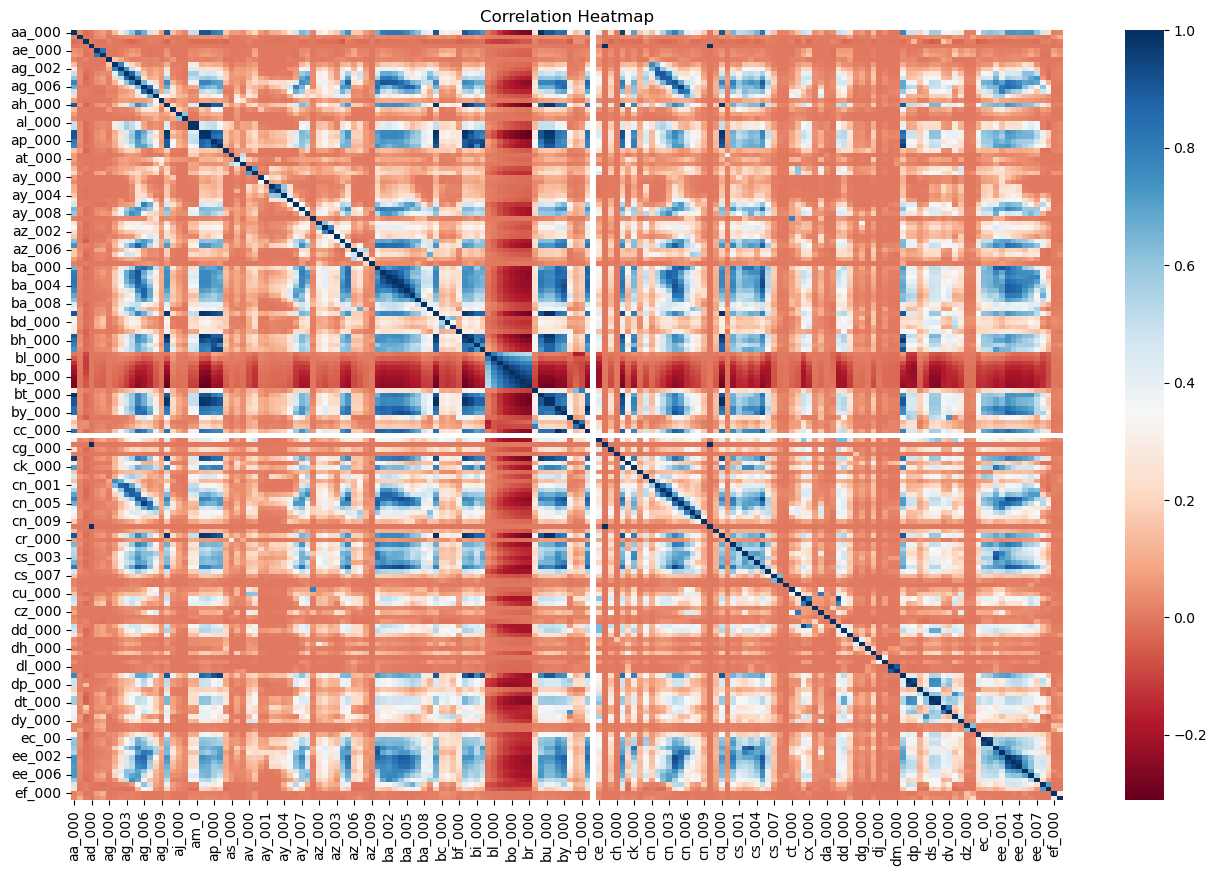

In [16]:
plt.close()
plt.figure(figsize=(16, 10))
heatmap = sns.heatmap(df_train_x.corr(), cmap='RdBu')
heatmap.set_title('Correlation Heatmap');
plt.show()

### iv. Pick $\lfloor\sqrt{170}\rfloor$ features with highest CV , and make scatter plots and box plots for them, similar to those on p. 129 of ISLR. Can you draw conclusions about significance of those features, just by the scatter plots? This does not mean that you will only use those features in the following questions. We picked them only for visualization.

In [28]:
number_of_features = int(math.sqrt(170))
highest_cv_features = cv.sort_values(ascending=False)[:number_of_features]

print("highest_cv_features:", highest_cv_features)
print("\n")

selected_features = highest_cv_features.index.to_list()

df_all_x_selected = df_all_x[selected_features]
df_all_selected = pd.concat([df_all_x_selected, df_all_y], axis=1)
print("df_all_selected: ", df_all_selected)

highest_cv_features: cs_009    235.277605
cf_000    184.233092
co_000    183.949017
ad_000    183.847620
dh_000    114.984991
dj_000    109.647285
ag_000     91.878565
as_000     86.416904
ay_009     83.786063
az_009     76.967978
ak_000     74.526688
au_000     68.160554
ch_000     58.268229
dtype: float64


df_all_selected:        cs_009         cf_000         co_000         ad_000 dh_000 dj_000  \
0        0.0            2.0          220.0          280.0    0.0    0.0   
1        0.0  150231.156793  150517.375485  150629.962105    0.0    0.0   
2        0.0            0.0            0.0          100.0    0.0    0.0   
3        0.0            2.0            2.0           66.0    0.0    0.0   
4        0.0            0.0          202.0          458.0    0.0    0.0   
...      ...            ...            ...            ...    ...    ...   
75995    0.0            2.0           42.0          892.0    0.0    0.0   
75996    0.0            2.0            0.0           46.0    0.0    0.0

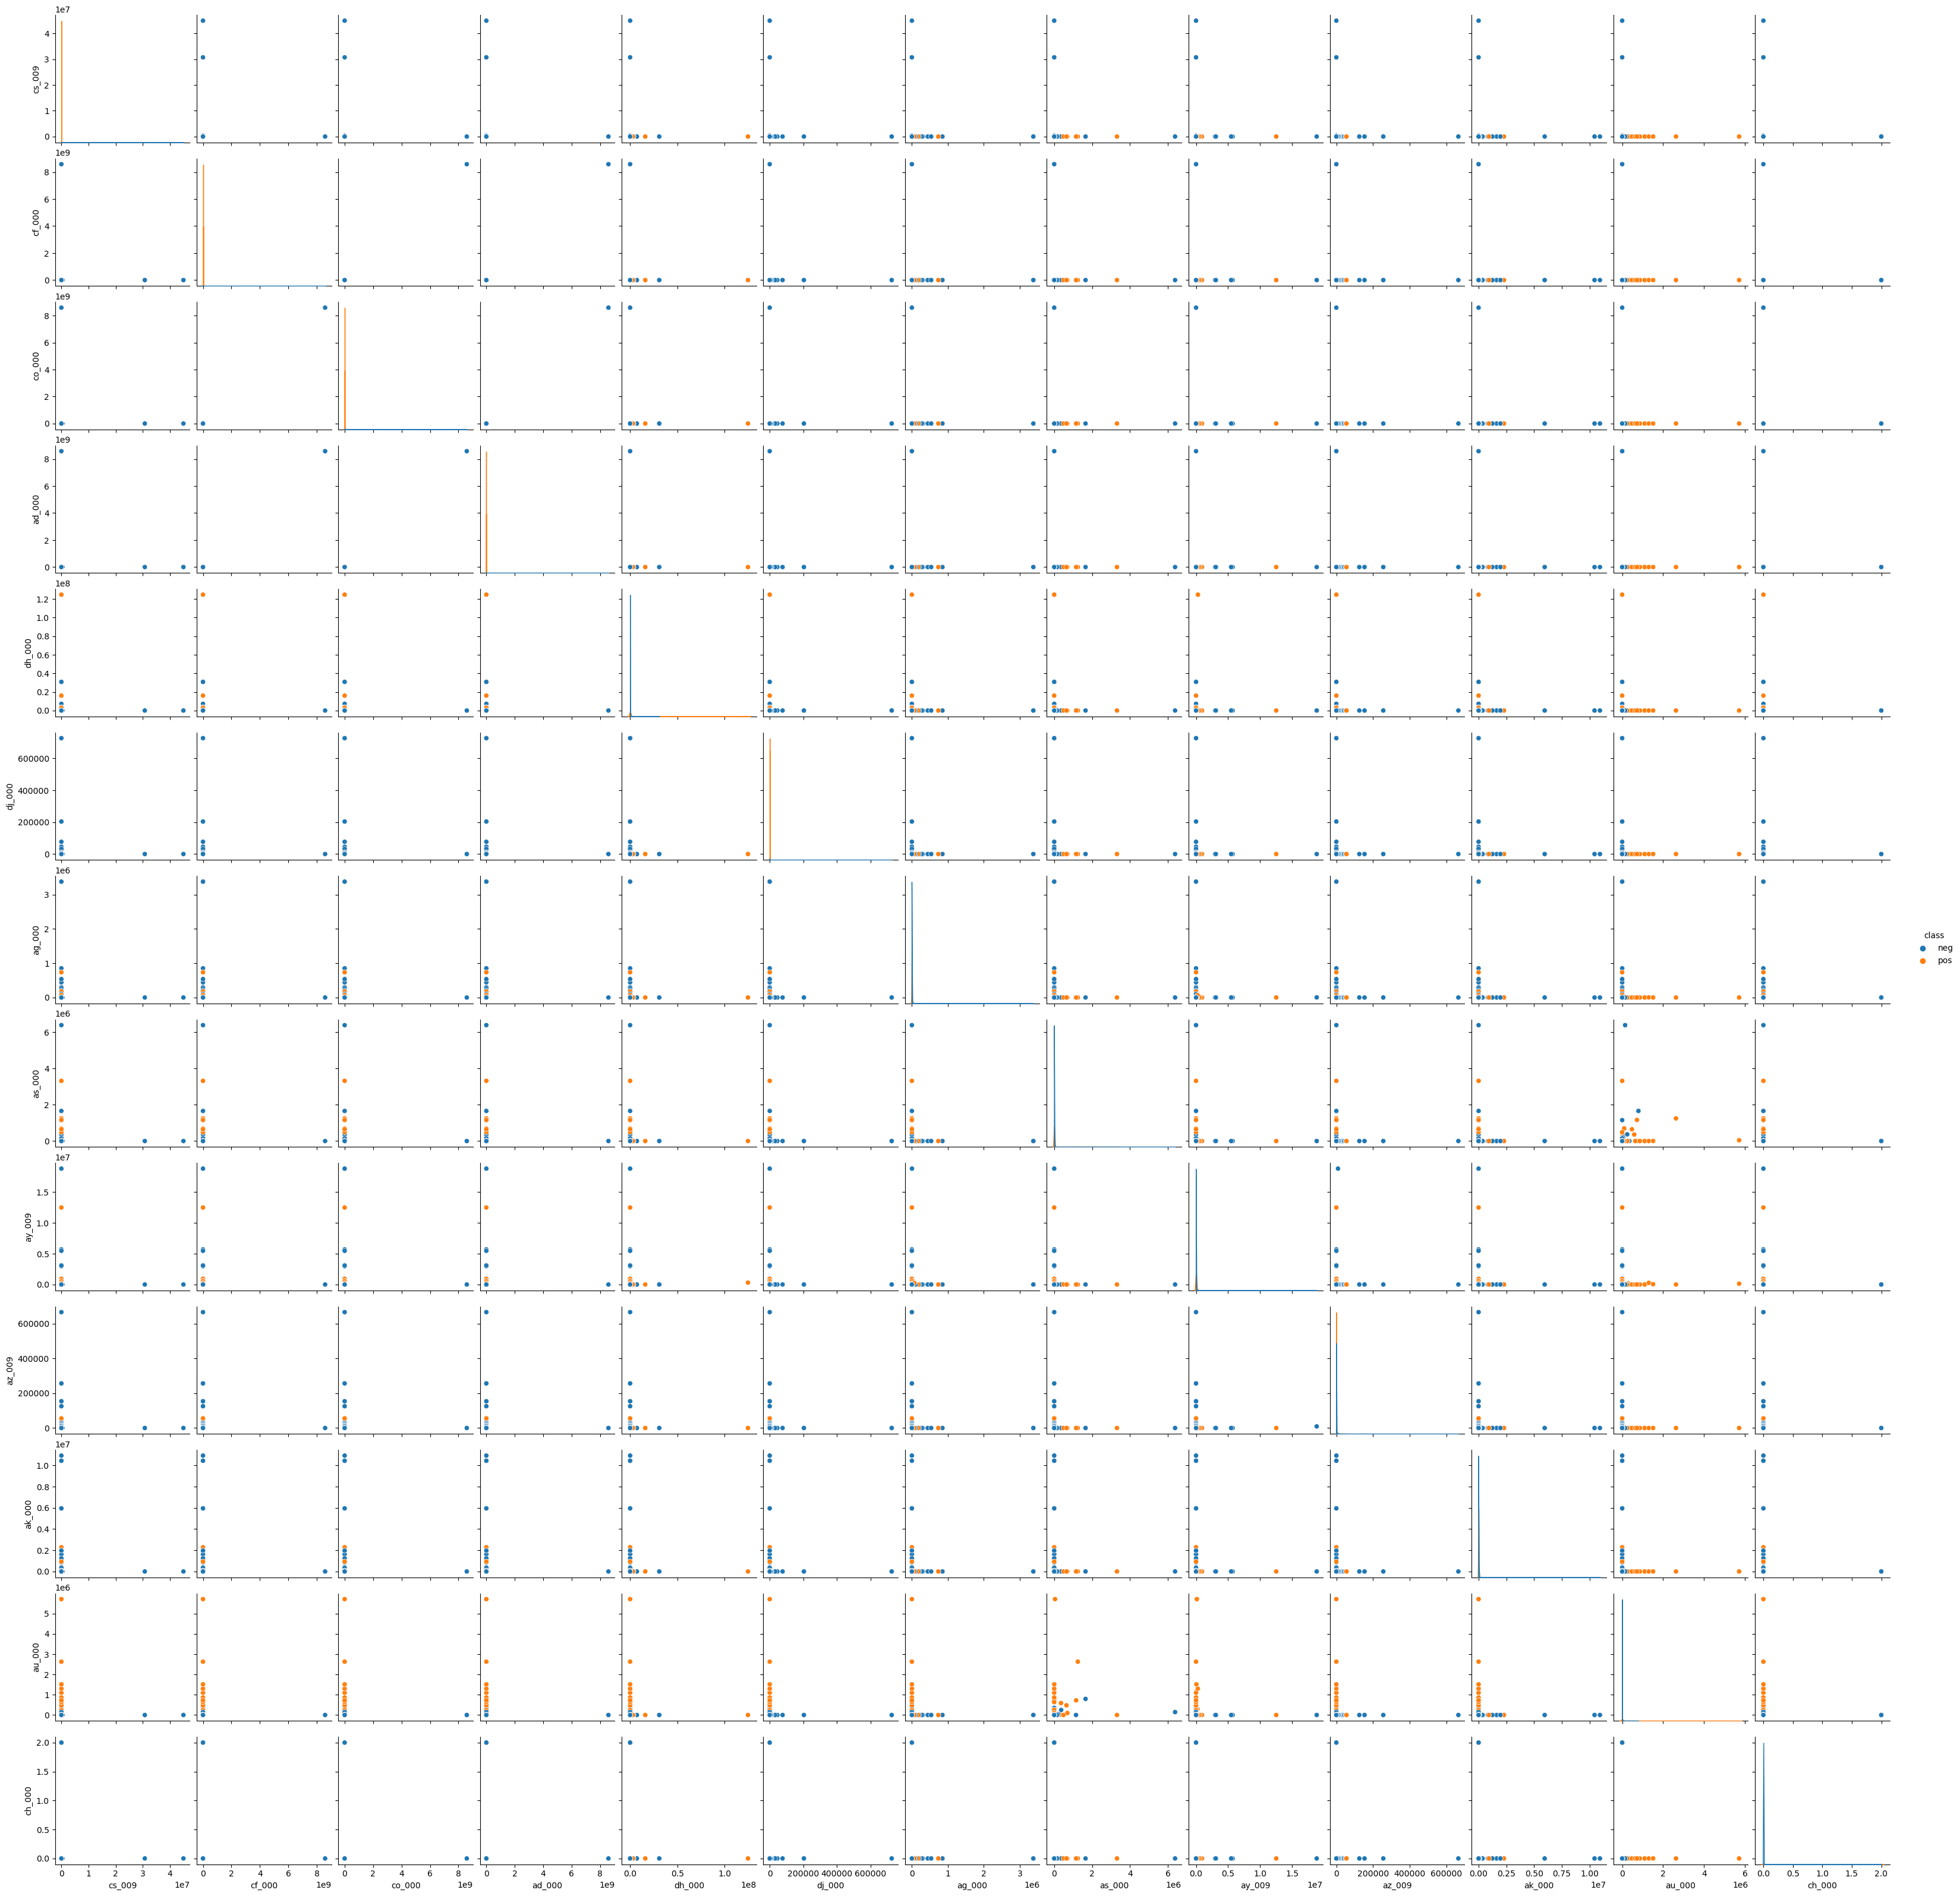

In [29]:
sns.pairplot(df_all_selected, hue='class')

I don't think we can draw any major conclusions about the significance of the features just by looking at the scatter plots.

[None]

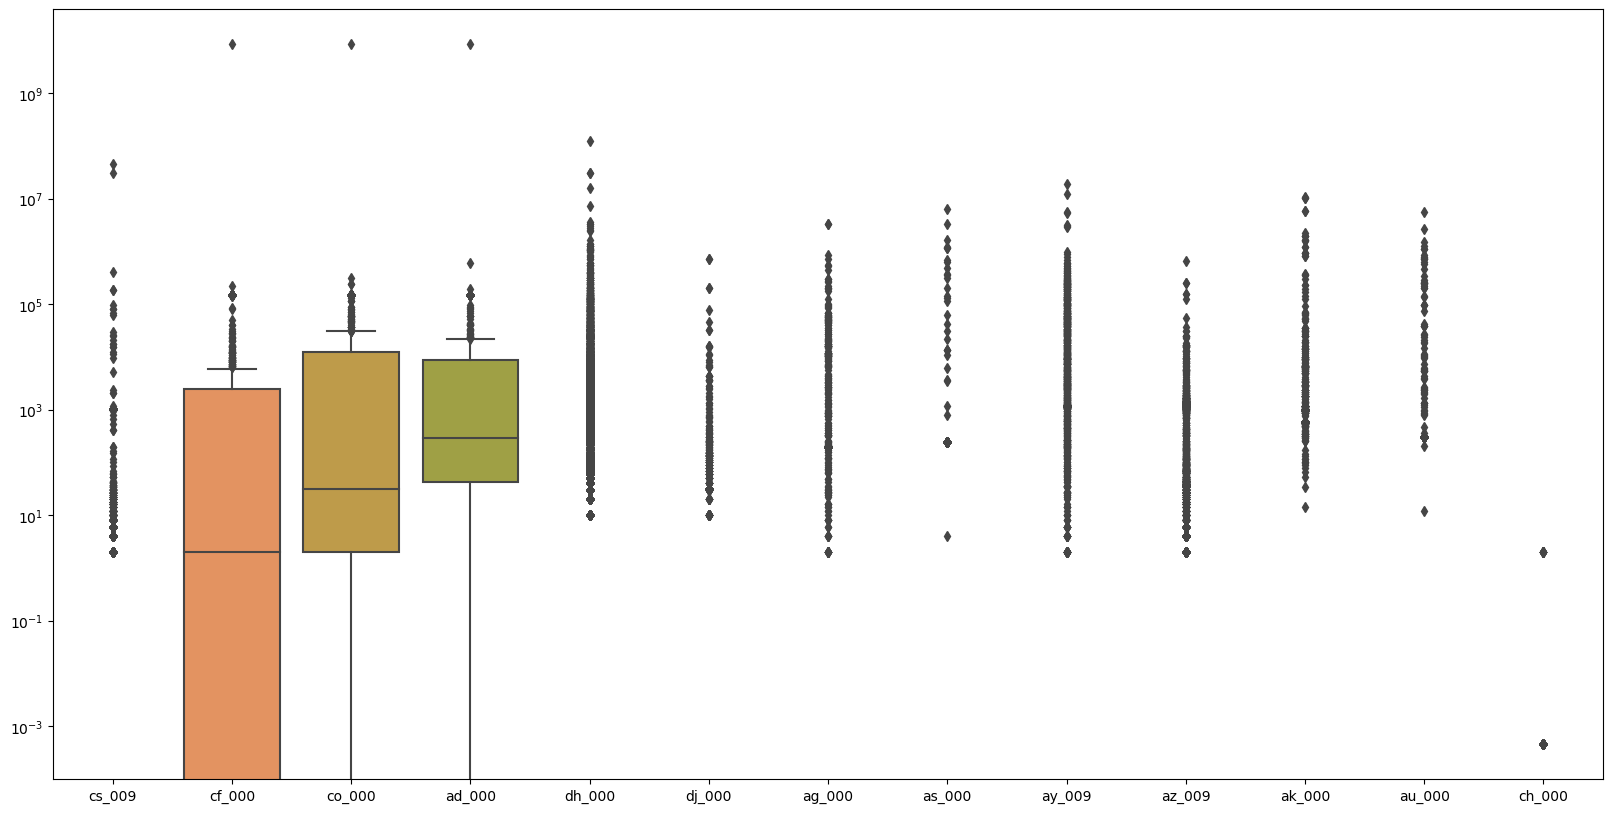

In [32]:
fig, ax = plt.subplots(figsize=(20,10))
boxplot = sns.boxplot(ax= ax, data=df_all_selected)
boxplot.set(yscale="log")

### v. Determine the number of positive and negative data. Is this data set imbalanced?

In [33]:
df_all_selected['class'].value_counts()

class
neg    74625
pos     1375
Name: count, dtype: int64

Yes, the dataset is imbalanced since there are many more neg class than pos class.

### (c) Train a random forest to classify the data set. Do NOT compensate for class imbalance in the data set. Calculate the confusion matrix, ROC, AUC, and misclassification for training and test sets and report them (You may use pROC package). Calculate Out of Bag error estimate for your random forest and compare it to the test error.

In [25]:
def train_model(model_state, df_train_x, df_train_y):
    if(model_state == 'balanced'):
        model = RandomForestClassifier(max_depth=5, random_state=7, n_jobs=-1, oob_score=True, class_weight = "balanced")
    else:
        model = RandomForestClassifier(max_depth=5, random_state=7, n_jobs=-1, oob_score=True)
    model.fit(df_train_x, df_train_y)
    return model

def evaluate_model1(model, df_test_x, df_test_y):
    ypred = model.predict(df_test_x)
    accuracy = accuracy_score(df_test_y, ypred)
    testerror = 1 - accuracy
    ooberr = 1 - model.oob_score_
    return accuracy, testerror, ooberr

def plot_confusion_matrix1(cm, classes, title):
    Misclassification = cm[0,1] + cm[1,0]
    print('Misclassification for', title, 'data is:', Misclassification)
    print("Confusion Matrix:\n",cm)

def plot_roc_curve1(model, df_x, df_y, title):
    predy = model.predict(df_x)
    fpr, tpr, _ = roc_curve(df_y, predy)
    roc_auc = auc(fpr, tpr)
    print('ROC for', title, 'data')
    print('AUC:', roc_auc)
    plt.figure(figsize=(10,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title('ROC Curve for ' + title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()

In [26]:
label_encoder = LabelEncoder()
df_train_y_encoded = label_encoder.fit_transform(df_train_y)
df_test_y_encoded = label_encoder.transform(df_test_y)

In [27]:
model = train_model('unbalanced', df_train_x, df_train_y_encoded)

Test accuracy is: 0.98775
Test error is: 0.012249999999999983
Out of bag error is: 0.009183333333333321


Confusion matrix for train data
Misclassification for train data is: 482
Confusion Matrix:
 [[58969    31]
 [  451   549]]
ROC for train data
AUC: 0.7742372881355932


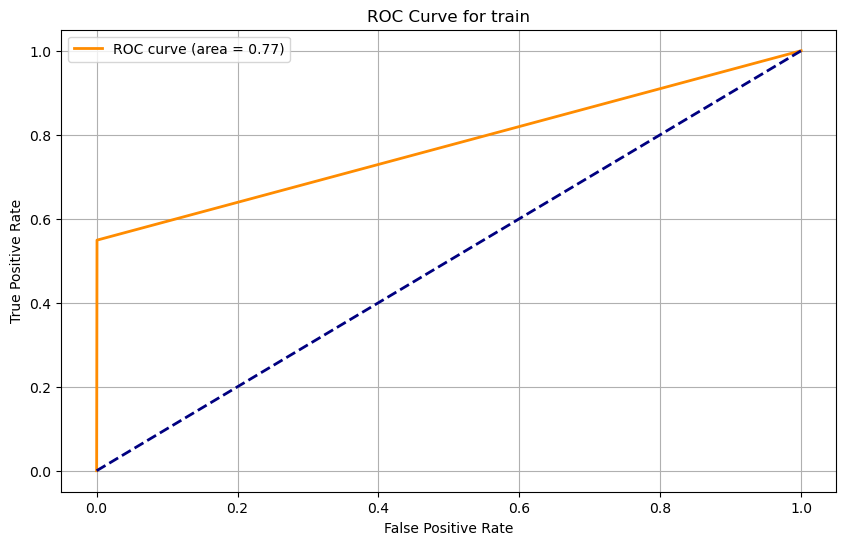



Confusion matrix for test data
Misclassification for test data is: 196
Confusion Matrix:
 [[15611    14]
 [  182   193]]
ROC for test data
AUC: 0.7568853333333334


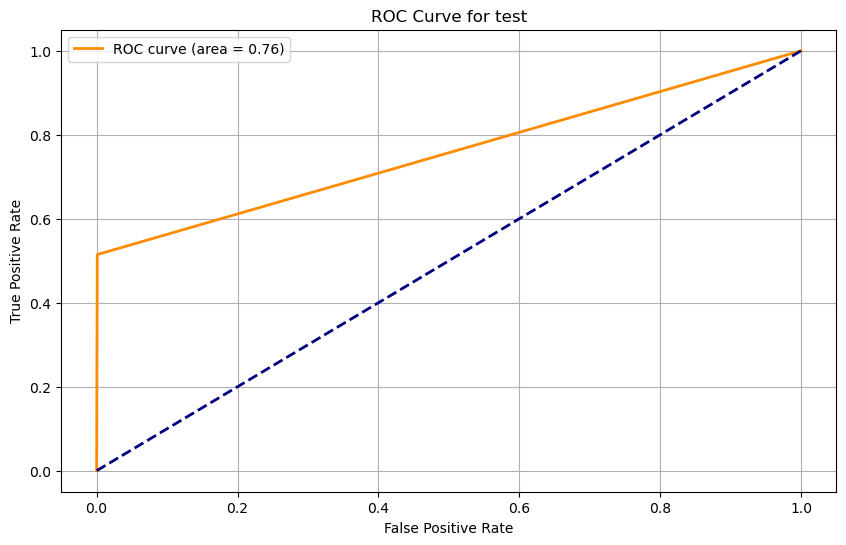

In [28]:
accuracy_ub, testerror_ub, ooberror_ub = evaluate_model1(model, df_test_x, df_test_y_encoded)
print("Test accuracy is:", accuracy_ub)
print('Test error is:', testerror_ub)
print('Out of bag error is:', ooberror_ub)
print("\n")
print('Confusion matrix for train data')
cm_train = confusion_matrix(df_train_y_encoded, model.predict(df_train_x))
plot_confusion_matrix1(cm_train, model.classes_, 'train')

plot_roc_curve1(model, df_train_x, df_train_y_encoded, 'train')
print("\n")
print('Confusion matrix for test data')
cm_test = confusion_matrix(df_test_y_encoded, model.predict(df_test_x))
plot_confusion_matrix1(cm_test, model.classes_, 'test')

plot_roc_curve1(model, df_test_x, df_test_y_encoded, 'test')

Comparing out of bag error estimate with test error: We see from above that out of bag error is lower than test error.

### (d) Research how class imbalance is addressed in random forests. Compensate for class imbalance in your random forest and repeat 1c. Compare the results with those of 1c.

How class imbalance is addressed in random forests:
- using Random Forest with class_weight parameter set as balanced
- using Random Forest with random undersampling

In [29]:
balanced_model = train_model('balanced', df_train_x, df_train_y_encoded)

Test accuracy is: 0.961375
Test error is: 0.03862500000000002
Out of bag error is: 0.04146666666666665


Confusion matrix for train data
Misclassification for train data is: 2410
Confusion Matrix:
 [[56619  2381]
 [   29   971]]
ROC for train data
AUC: 0.9653220338983052


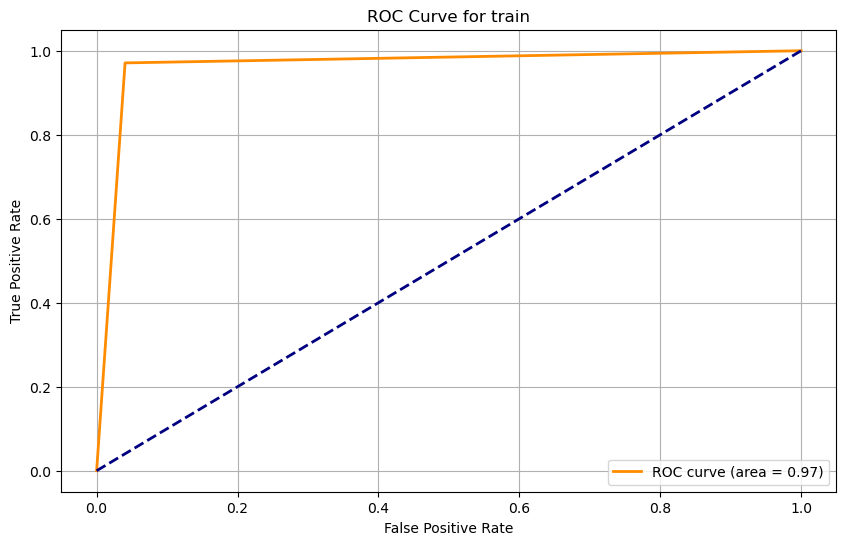



Confusion matrix for test data
Misclassification for test data is: 618
Confusion Matrix:
 [[15021   604]
 [   14   361]]
ROC for test data
AUC: 0.9620053333333334


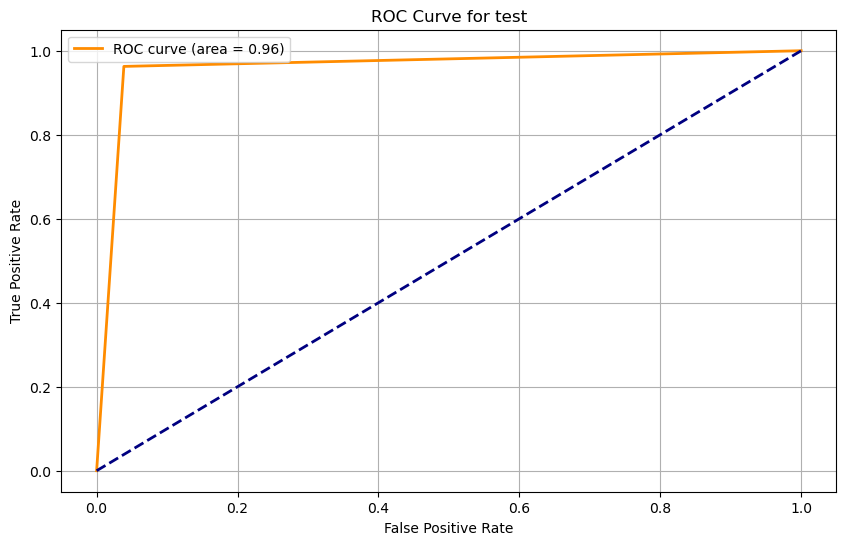

In [30]:
accuracy_b, testerror_b, ooberror_b = evaluate_model1(balanced_model, df_test_x, df_test_y_encoded)
print("Test accuracy is:", accuracy_b)
print('Test error is:', testerror_b)
print('Out of bag error is:', ooberror_b)
print("\n")
print('Confusion matrix for train data')
cm_train = confusion_matrix(df_train_y_encoded, balanced_model.predict(df_train_x))
plot_confusion_matrix1(cm_train, model.classes_, 'train')
plot_roc_curve1(balanced_model, df_train_x, df_train_y_encoded, 'train')
print("\n")
print('Confusion matrix for test data')
cm_test = confusion_matrix(df_test_y_encoded, balanced_model.predict(df_test_x))
plot_confusion_matrix1(cm_test, balanced_model.classes_, 'test')
plot_roc_curve1(balanced_model, df_test_x, df_test_y_encoded, 'test')

In [31]:
print("Comparing 1c and 1d results:\n");

print("\nAccuracy:\n")
print("\n         1c result: ", accuracy_ub);
print("\n         1d result: ", accuracy_b);

print("\nTest error:\n")
print("\n         1c result: ", testerror_ub);
print("\n         1d result: ", testerror_b);

print("\nOut of bag error:\n")
print("\n         1c result: ", ooberror_ub);
print("\n         1d result: ", ooberror_b);

Comparing 1c and 1d results:


Accuracy:


         1c result:  0.98775

         1d result:  0.961375

Test error:


         1c result:  0.012249999999999983

         1d result:  0.03862500000000002

Out of bag error:


         1c result:  0.009183333333333321

         1d result:  0.04146666666666665


As we can see from the above results, the accuracy for the balanced model is lower than that of unbalanced model. Its error is higher. But as we can see from the confusion matrix, for the balanced model, we have achieved better prediction of the minority class ('pos' class). The number of correctly classified 'pos' in unbalanced model is 193, whereas number of correctly classified 'pos' in balanced model is 361, which is much higher.

### (e) XGBoost and Model Trees
### In the case of a univariate tree, only one input dimension is used at a tree split. In a multivariate tree, or model tree, at a decision node all input dimensions can be used and thus it is more general. In univariate classification trees, majority polling is used at each node to determine the split of that node as the decision rule. In model trees, a (linear) model that relies on all of the variables is used to determine the split of that node (i.e. instead of using $X_j$ > s as the decision rule, one has $\Sigma_jβ_jX_j$ > s. as the decision rule). Alternatively, in a regression tree, instead of using average in the region associated with each node, a linear regression model is used to determine the value associated with that node.

### One of the methods that can be used at each node is Logistic Regression. Because the number of variables is large in this problem, one can use L1-penalized logistic regression at each node. You can use XGBoost to fit the model tree. Determine α (the regularization term) using cross-validation. Train the model for the APS data set without compensation for class imbalance. Use one of 5 fold, 10 fold, and leave-one-out cross validation methods to estimate the error of your trained model and compare it with the test error. Report the Confusion Matrix, ROC, and AUC for training and test sets.

In [3]:
xgb_train_X = df_train_const.iloc[:, 1:]
xgb_train_Y = df_train_const.iloc[:, 0]
xgb_test_X = df_test_const.iloc[:, 1:]
xgb_test_Y = df_test_const.iloc[:, 0]

imputer_redo = SimpleImputer(missing_values=np.nan, strategy='mean')

xgb_train_X_imputed = pd.DataFrame(imputer_redo.fit_transform(xgb_train_X), columns=df_train_const.columns[1:])
xgb_test_X_imputed = pd.DataFrame(imputer_redo.fit_transform(xgb_test_X), columns=df_test_const.columns[1:])

Ytest_xgb = xgb_test_Y.map({'pos': 1, 'neg': 0})
Ytrain_xgb = xgb_train_Y.map({'pos': 1, 'neg': 0})

In [4]:
def cross_validate_alphas(alpha_values, X_train, y_train):
    cv_results = pd.DataFrame(columns=['alpha', 'CV_Score'])
    k_fold = StratifiedKFold(n_splits=5)

    for alpha in alpha_values:
        x_model = xgb.XGBClassifier(objective='binary:logistic', learning_rate=0.0001, reg_alpha=alpha)
        cv_scores = cross_val_score(x_model, X_train, y_train, cv=k_fold, scoring="f1", n_jobs=-1)
        alpha_score_df = pd.DataFrame({'alpha': alpha, 'CV_Score': np.max(cv_scores)}, index=[0])
        cv_results = pd.concat([cv_results, alpha_score_df], ignore_index=True)

    return cv_results

def find_best_alpha(cv_results):
    best_alpha_row = cv_results.loc[cv_results['CV_Score'].idxmax()]
    return best_alpha_row['alpha'], best_alpha_row['CV_Score']

def train_xgb_model(alpha, X_train, y_train):
    xg_model = xgb.XGBClassifier(objective='binary:logistic', learning_rate=0.0001, reg_alpha=alpha)
    xg_model.fit(X_train, y_train)
    return xg_model

def evaluate_model2(model, X, y, data_type):
    predictions = model.predict(X)
    accuracy = accuracy_score(y, predictions)
    confusion_matrix_result = confusion_matrix(y, predictions)
    missclassification = confusion_matrix_result[0, 1] + confusion_matrix_result[1, 0]
    print(f'Confusion Matrix of {data_type} Data:')
    print(confusion_matrix_result)
    print(f'{data_type} Classification Accuracy: {accuracy}')
    print(f'Missclassification for the set: {missclassification}')
    return accuracy, missclassification

def plot_roc_curve2(X, y, model, data_type):
    prob = model.predict_proba(X)
    fpr, tpr, thresholds = roc_curve(y, prob[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    print('AUC:', roc_auc)
    plt.close()
    plt.figure(figsize=(10,6))
    plt.plot(fpr, tpr, color='darkorange', label="Area Under Curve(AUC): {}".format(roc_auc))
    plt.plot([0,1], [0,1], color='navy', linestyle='--')
    plt.title(f'ROC Curve for {data_type} Data')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()


In [6]:
alpha_values = [10 ** i for i in range(-4, 4)]
cv_results = cross_validate_alphas(alpha_values, xgb_train_X_imputed, Ytrain_xgb)
best_alpha, best_cv_score = find_best_alpha(cv_results)
print(f'Best alpha is {best_alpha}')

Best alpha is 0.0001


In [7]:
xg_model = train_xgb_model(best_alpha, xgb_train_X_imputed, Ytrain_xgb)

Confusion Matrix of Train Data:
[[59000     0]
 [ 1000     0]]
Train Classification Accuracy: 0.9833333333333333
Missclassification for the set: 1000
AUC: 0.9525659745762711


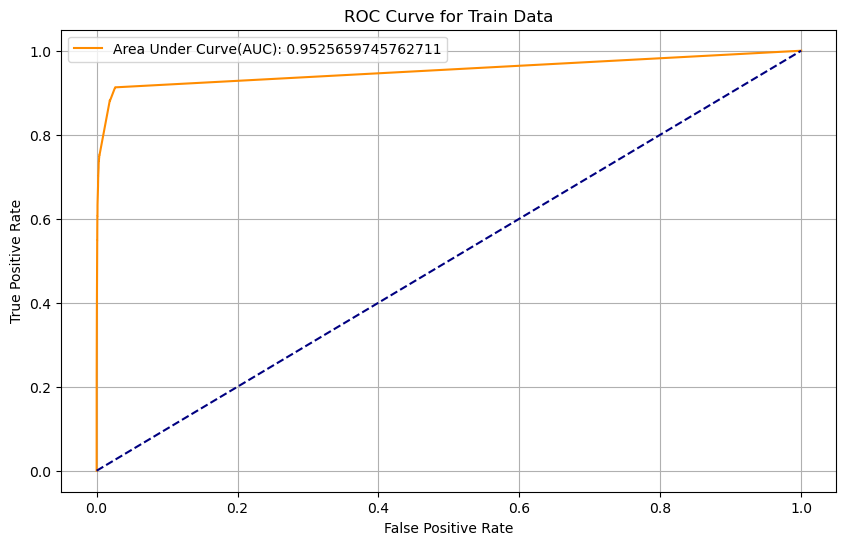

Confusion Matrix of Test Data:
[[15625     0]
 [  375     0]]
Test Classification Accuracy: 0.9765625
Missclassification for the set: 375
AUC: 0.9563661653333334


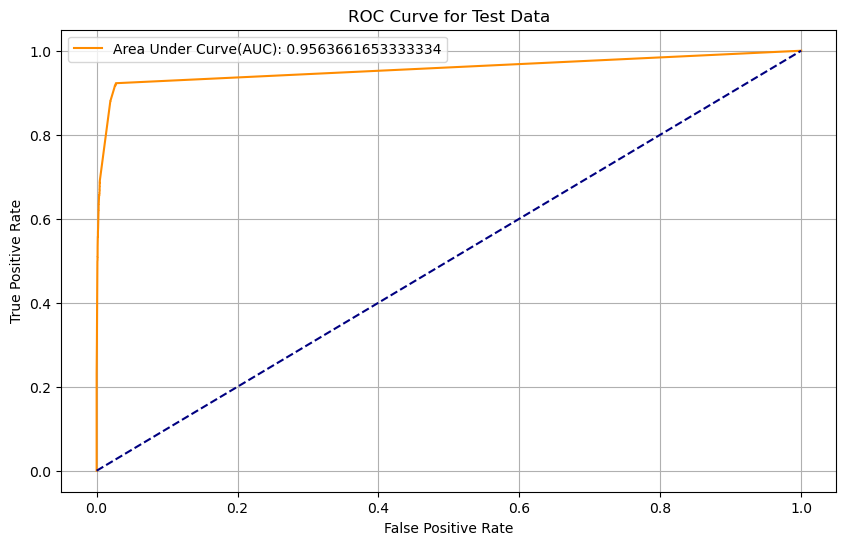

Comparing train error and test error:

Train error:  0.01666666666666672
Test error:  0.0234375


In [8]:
train_accuracy, train_missclassification = evaluate_model2(xg_model, xgb_train_X_imputed, Ytrain_xgb, 'Train')
plot_roc_curve2(xgb_train_X_imputed, Ytrain_xgb, xg_model, 'Train')

test_accuracy, test_missclassification = evaluate_model2(xg_model, xgb_test_X_imputed, Ytest_xgb, 'Test')
plot_roc_curve2(xgb_test_X_imputed, Ytest_xgb, xg_model, 'Test')

print("Comparing train error and test error:\n")
print("Train error: ", 1-train_accuracy)
print("Test error: ", 1-test_accuracy)

### (f) Use SMOTE (Synthetic Minority Over-sampling Technique) to pre-process your data to compensate for class imbalance. Train XGBoost with L1-penalized logistic regression at each node using the pre-processed data and repeat 1e. Do not forget that there is a right and a wrong way of cross validation here. Compare the uncompensated case with SMOTE case.

In [5]:
## Reference: https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7
def train_smote_model(pipeline, best_params, X_train, y_train):
    final_model = pipeline.set_params(**best_params)
    final_model.fit(X_train, y_train)
    return final_model

In [6]:
sm = SMOTE(random_state=42)
xresampled, yresampled = sm.fit_resample(xgb_train_X_imputed, Ytrain_xgb)

pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)], ['classifier', xgb.XGBClassifier(objective="binary:logistic",use_label_encoder=False, eval_metric='logloss')]])
param_grid = {'classifier__reg_alpha':[1e-3, 1e-2, 1e-1, 1,1e+1,1e+2,1e+3]}
gridsearchsmote = GridSearchCV(estimator=pipeline, param_grid = param_grid, cv=5,scoring = 'f1')
gridsearchsmote = gridsearchsmote.fit(xresampled, yresampled)

In [7]:
best_params = gridsearchsmote.best_params_

In [8]:
final_model = train_smote_model(pipeline, best_params, xresampled, yresampled)

Best alpha for SMOTE is: 0.1
Confusion Matrix of Train Data:
[[59000     0]
 [    1 58999]]
Train Classification Accuracy: 0.9999915254237288
Missclassification for the set: 1
AUC: 0.9999997627118644


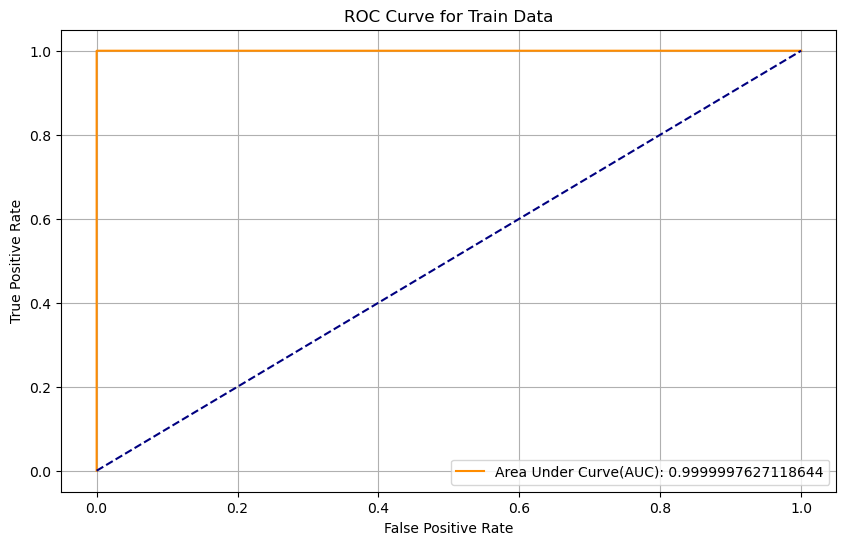



Confusion Matrix of Test Data:
[[15395   230]
 [   49   326]]
Test Classification Accuracy: 0.9825625
Missclassification for the set: 279
AUC: 0.990122496


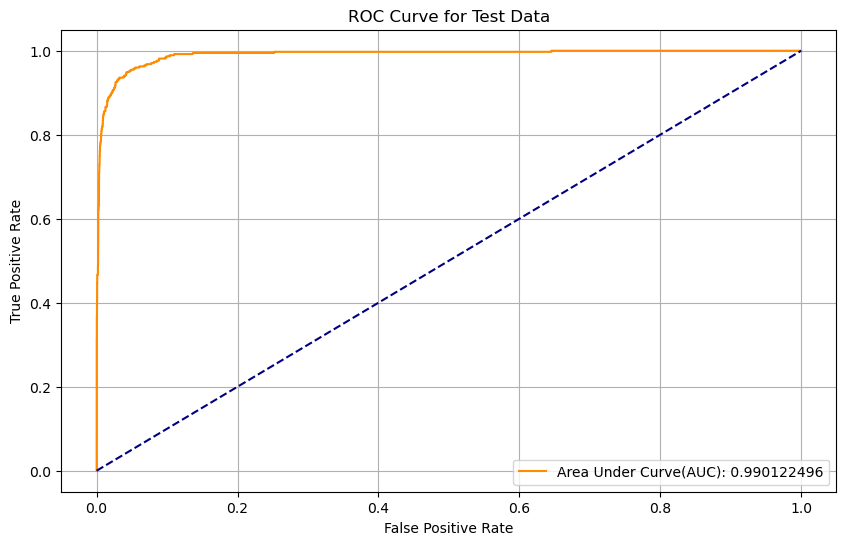

In [9]:
print('Best alpha for SMOTE is:', best_params['classifier__reg_alpha'])

test_accuracy, test_missclassification = evaluate_model2(final_model, xresampled, yresampled, 'Train')
plot_roc_curve2(xgb_train_X_imputed, Ytrain_xgb, final_model, 'Train')
print("\n")
test_accuracy, test_missclassification = evaluate_model2(final_model, xgb_test_X_imputed, Ytest_xgb, 'Test')
plot_roc_curve2(xgb_test_X_imputed, Ytest_xgb, final_model, 'Test')


Comparing uncompensated case with SMOTE case:
    
- We can see that the Test accuracy for SMOTE is slightly higher than the uncompensated case. But what we are really concerned about here is the correct prediction of the minority class. We see that SMOTE XGBoost model predicts minorty class ('pos' class) better than the XGBoost model. SMOTE model correctly classified 326 data points of the 'pos' class (and misclassified 49).

## 2. ISLR 6.6.3

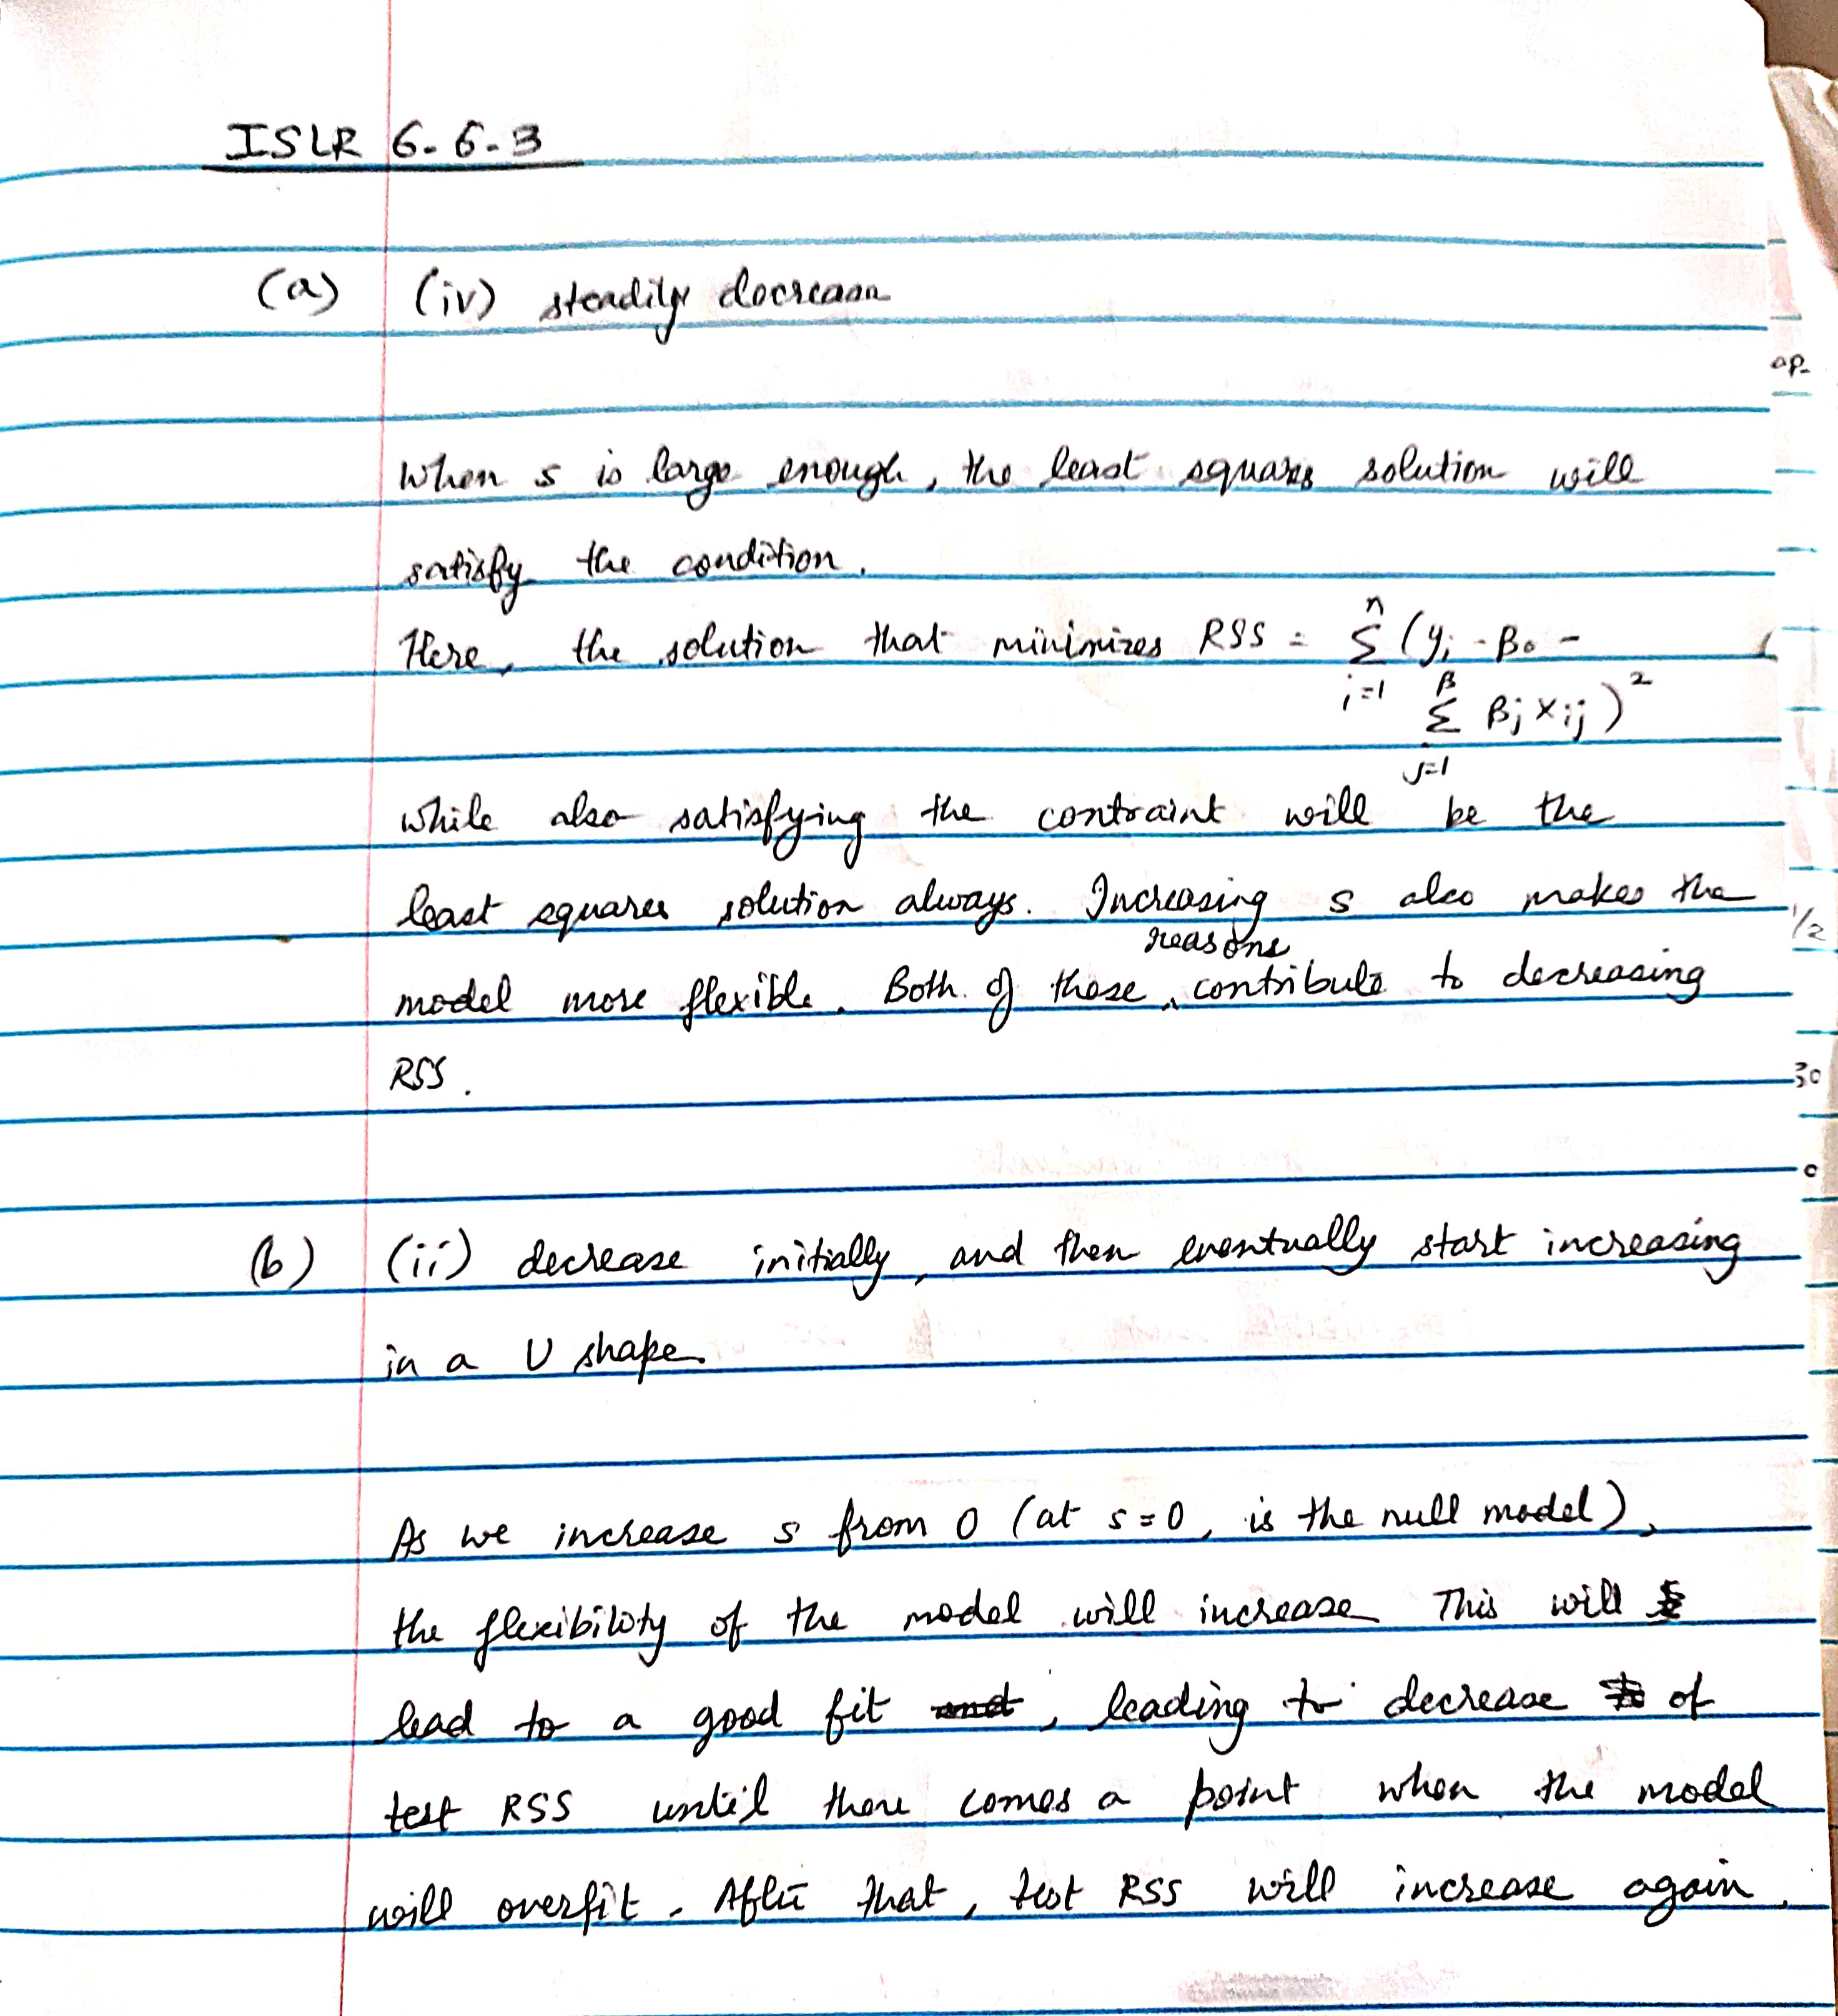

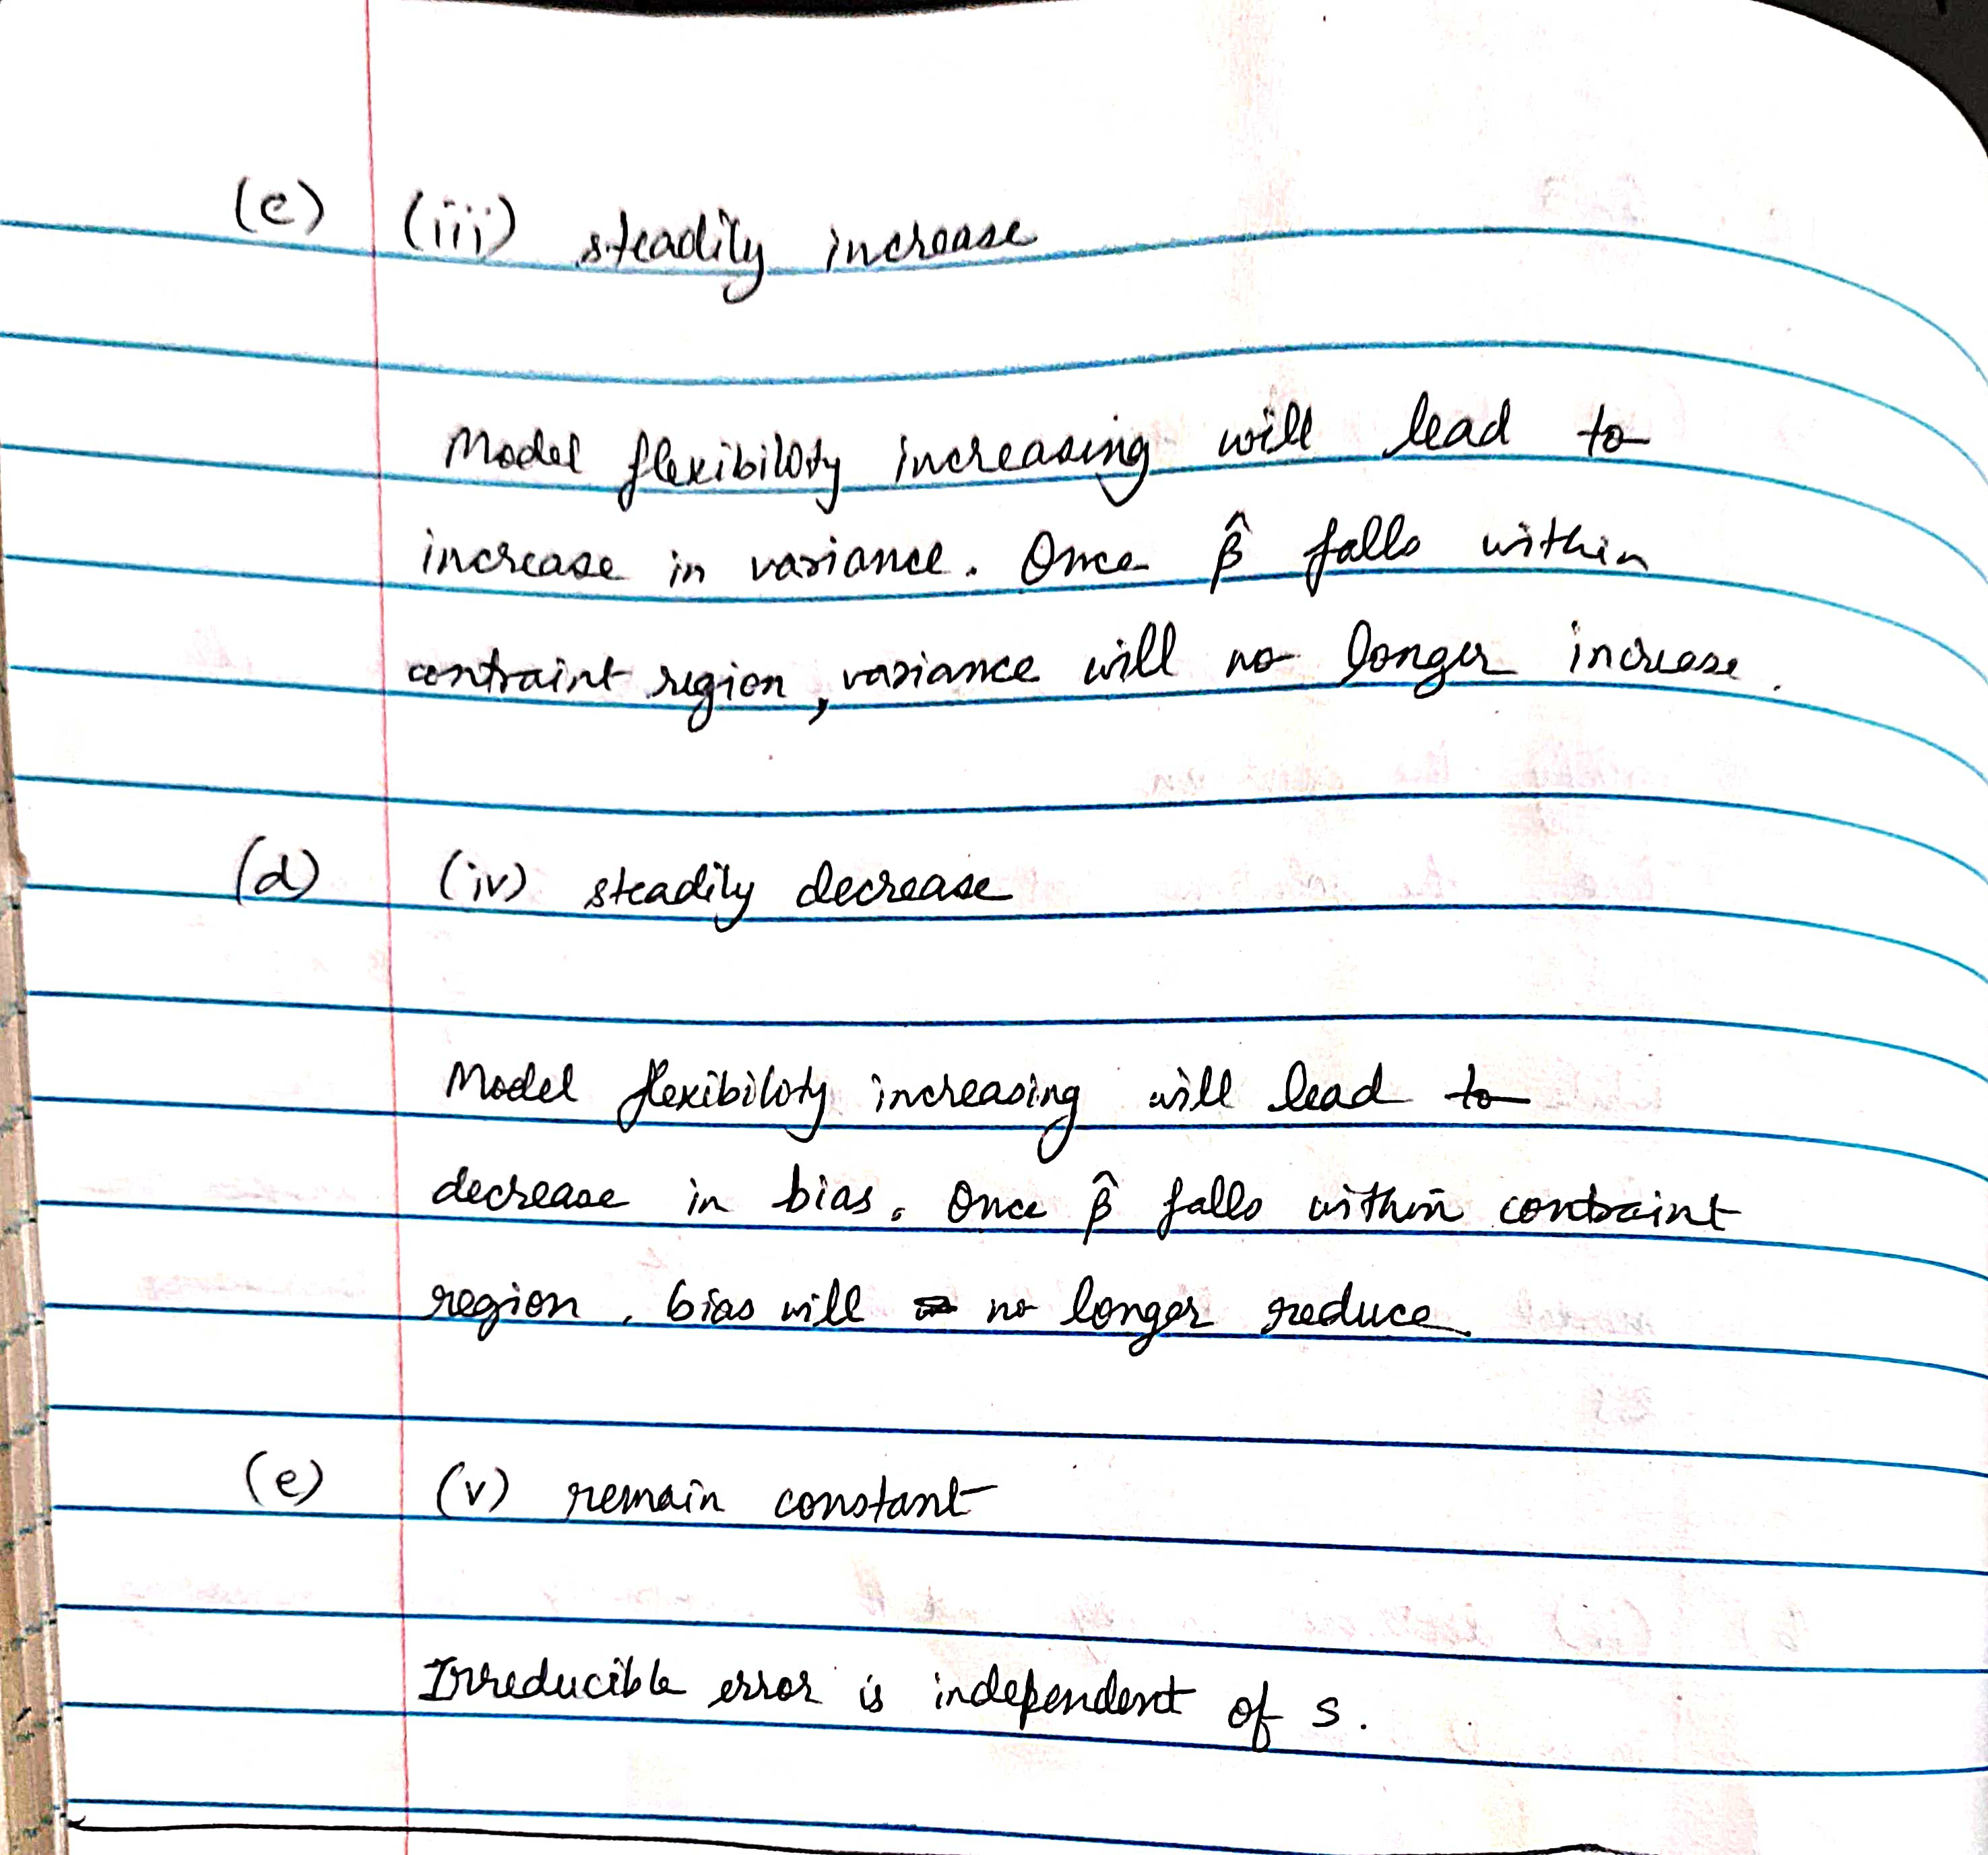

## 3. ISLR 6.6.5

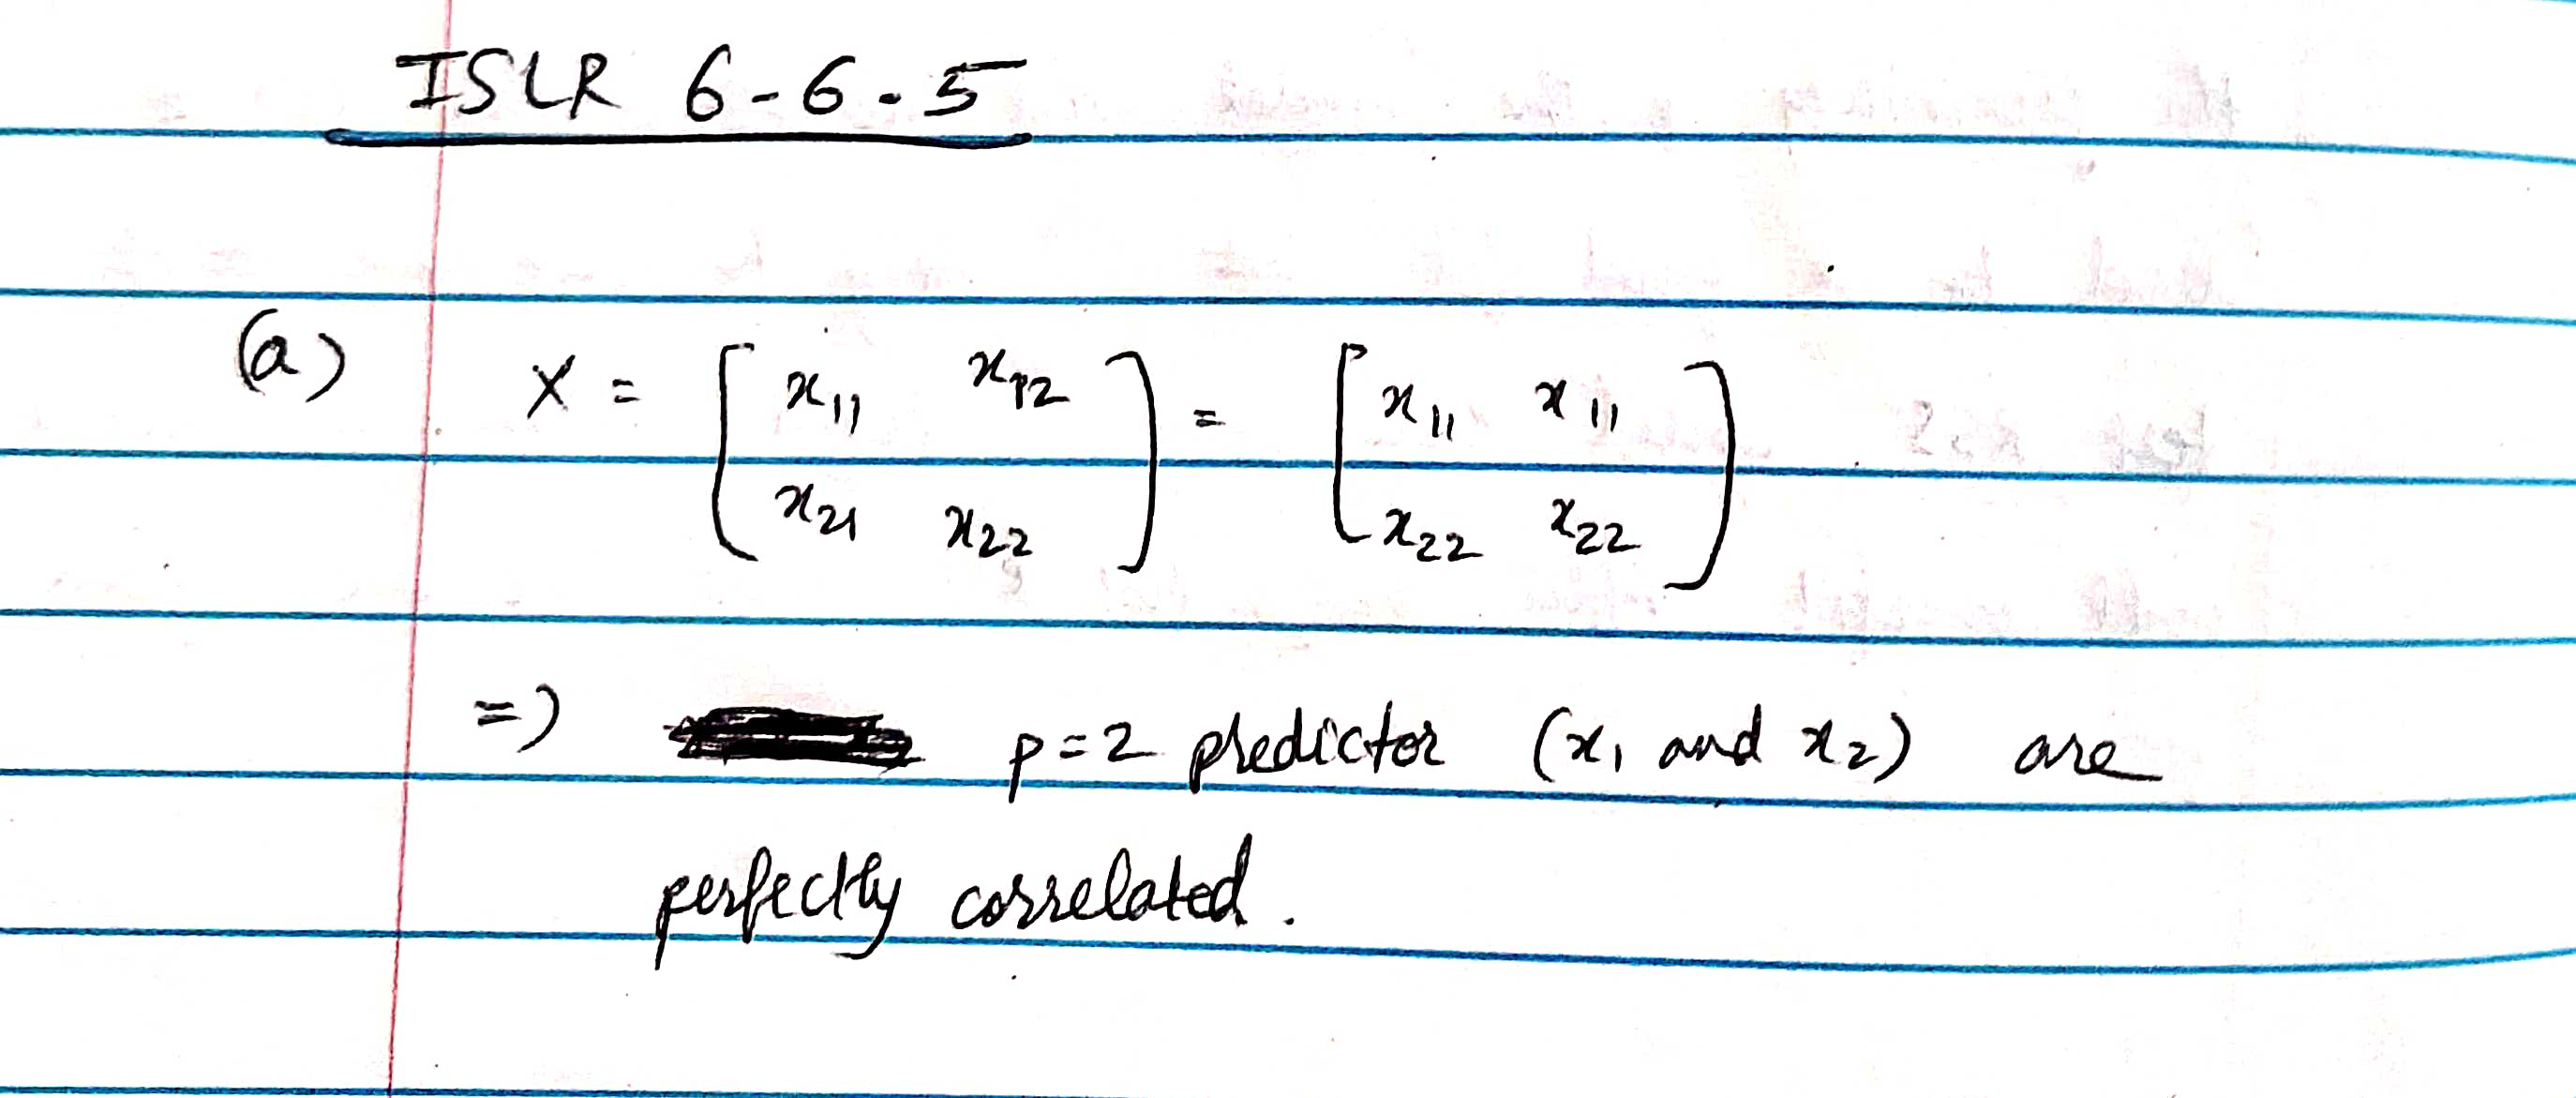

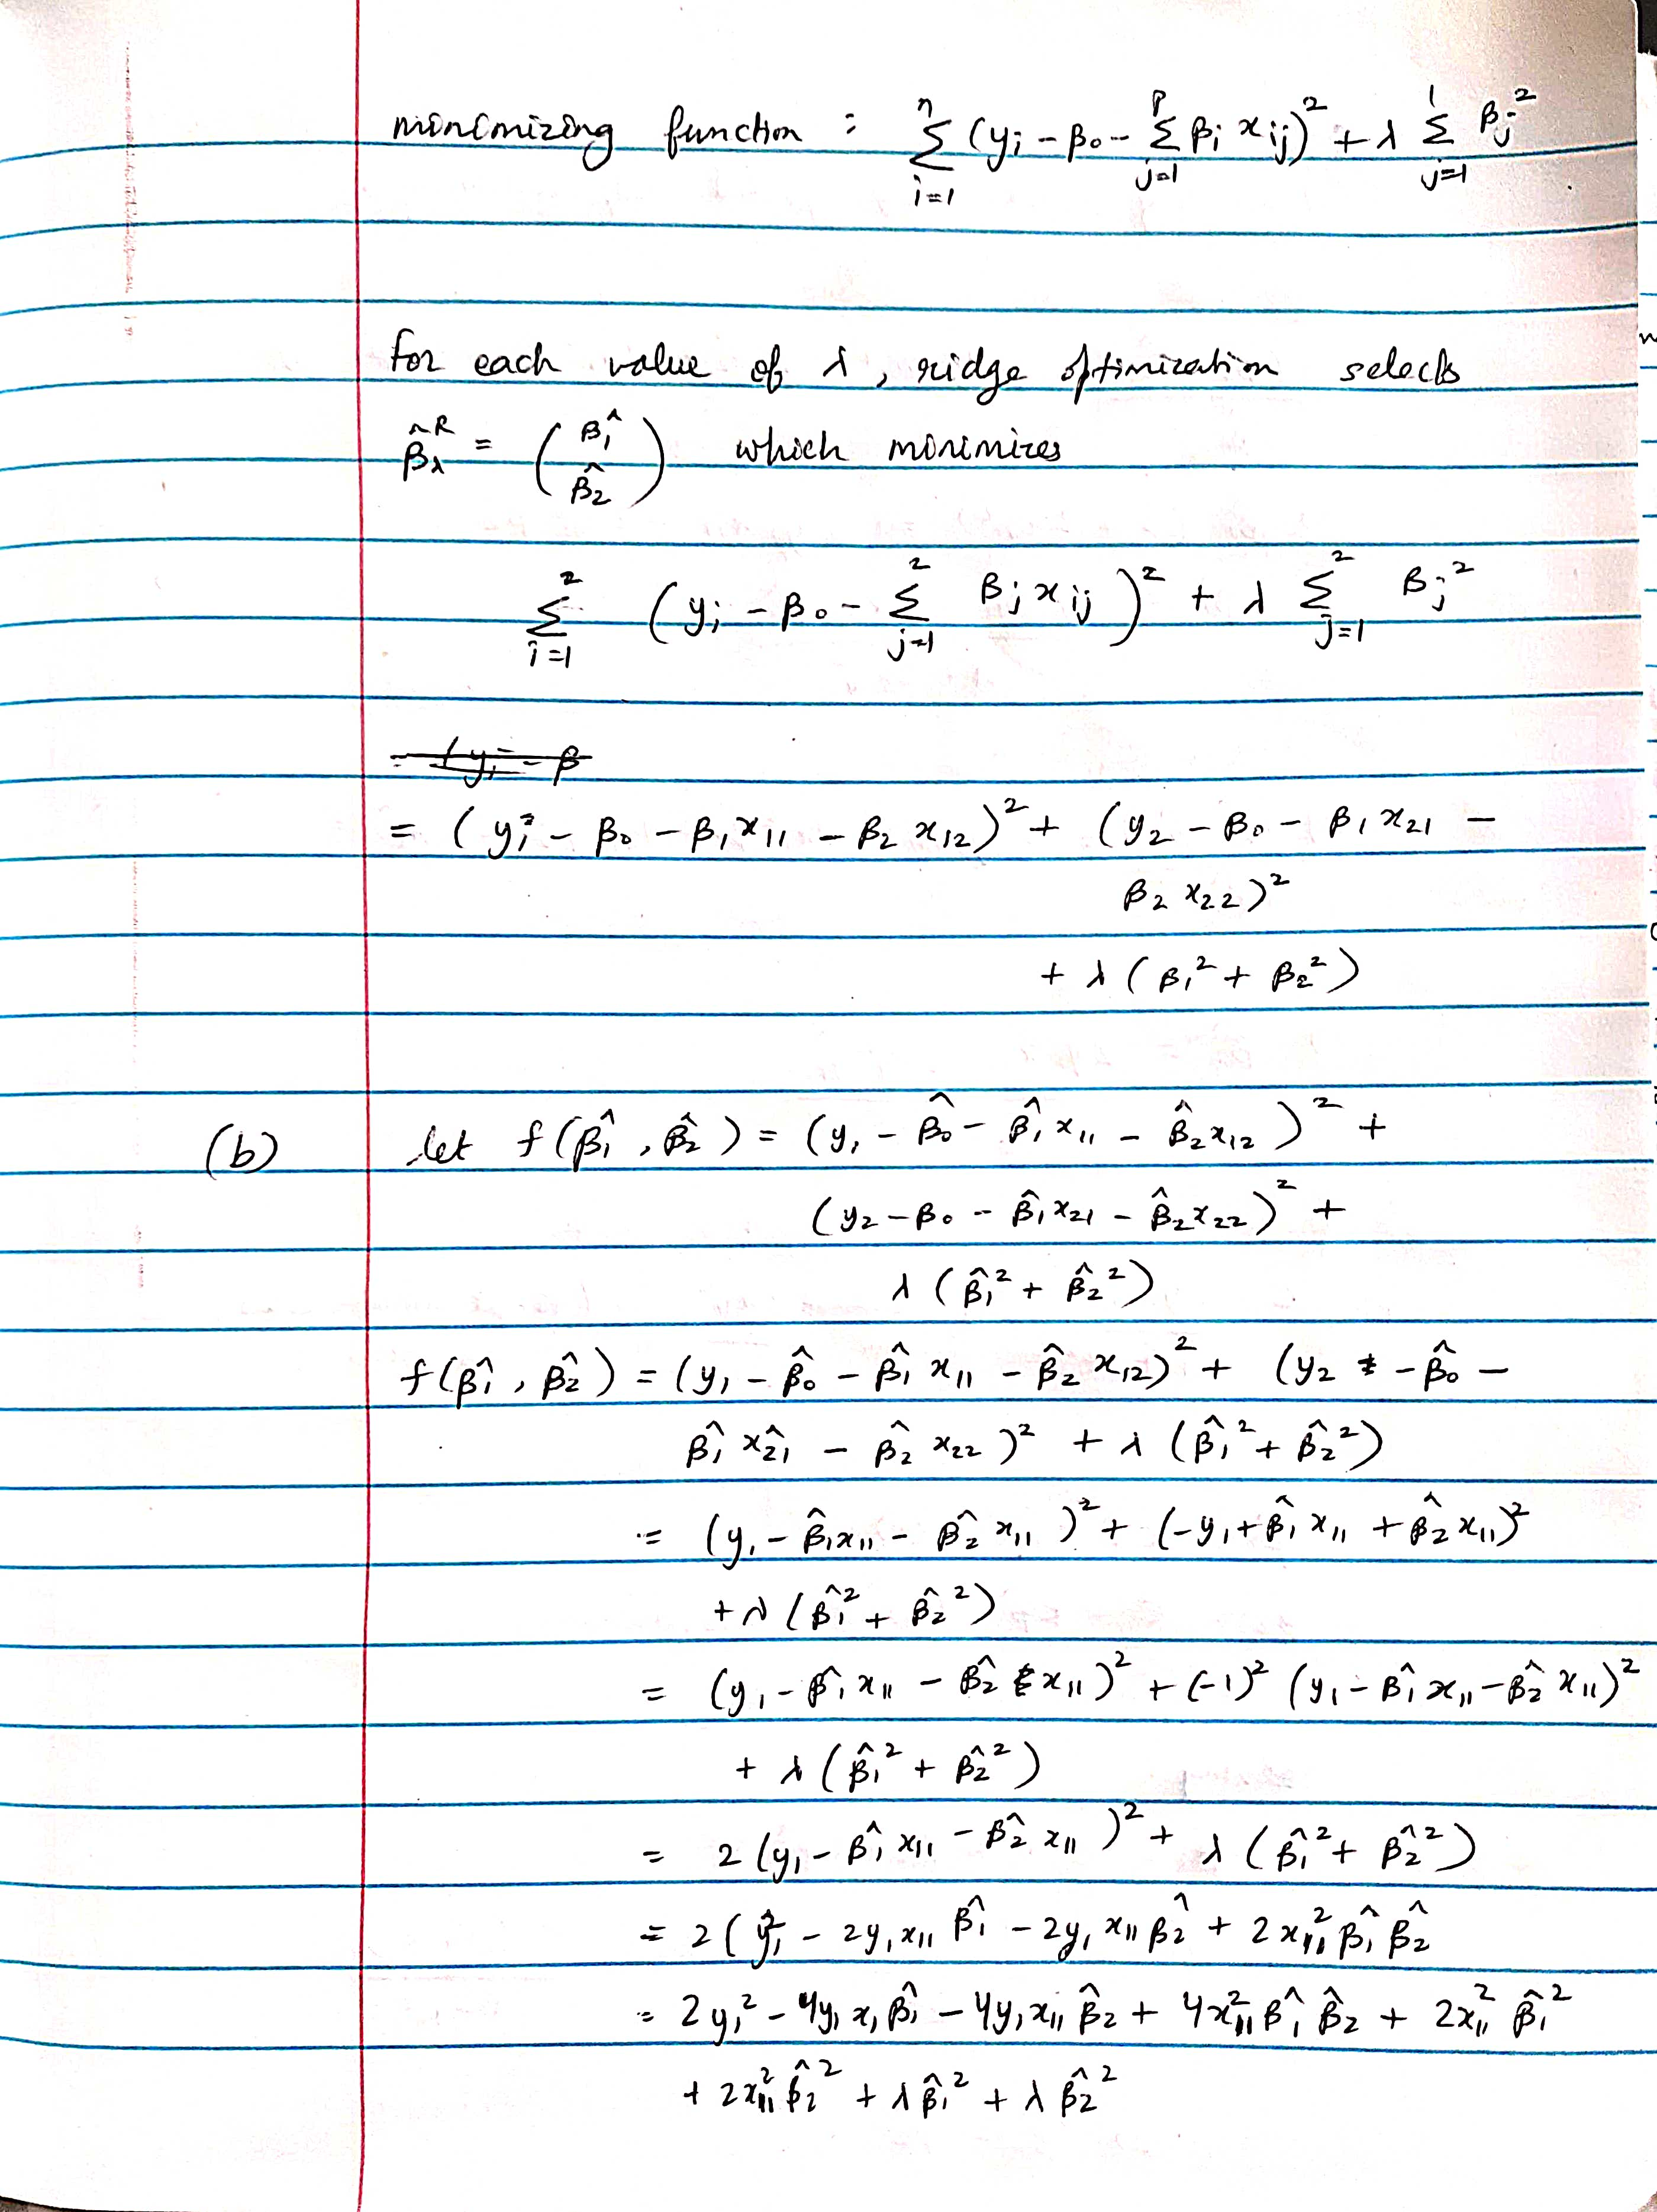

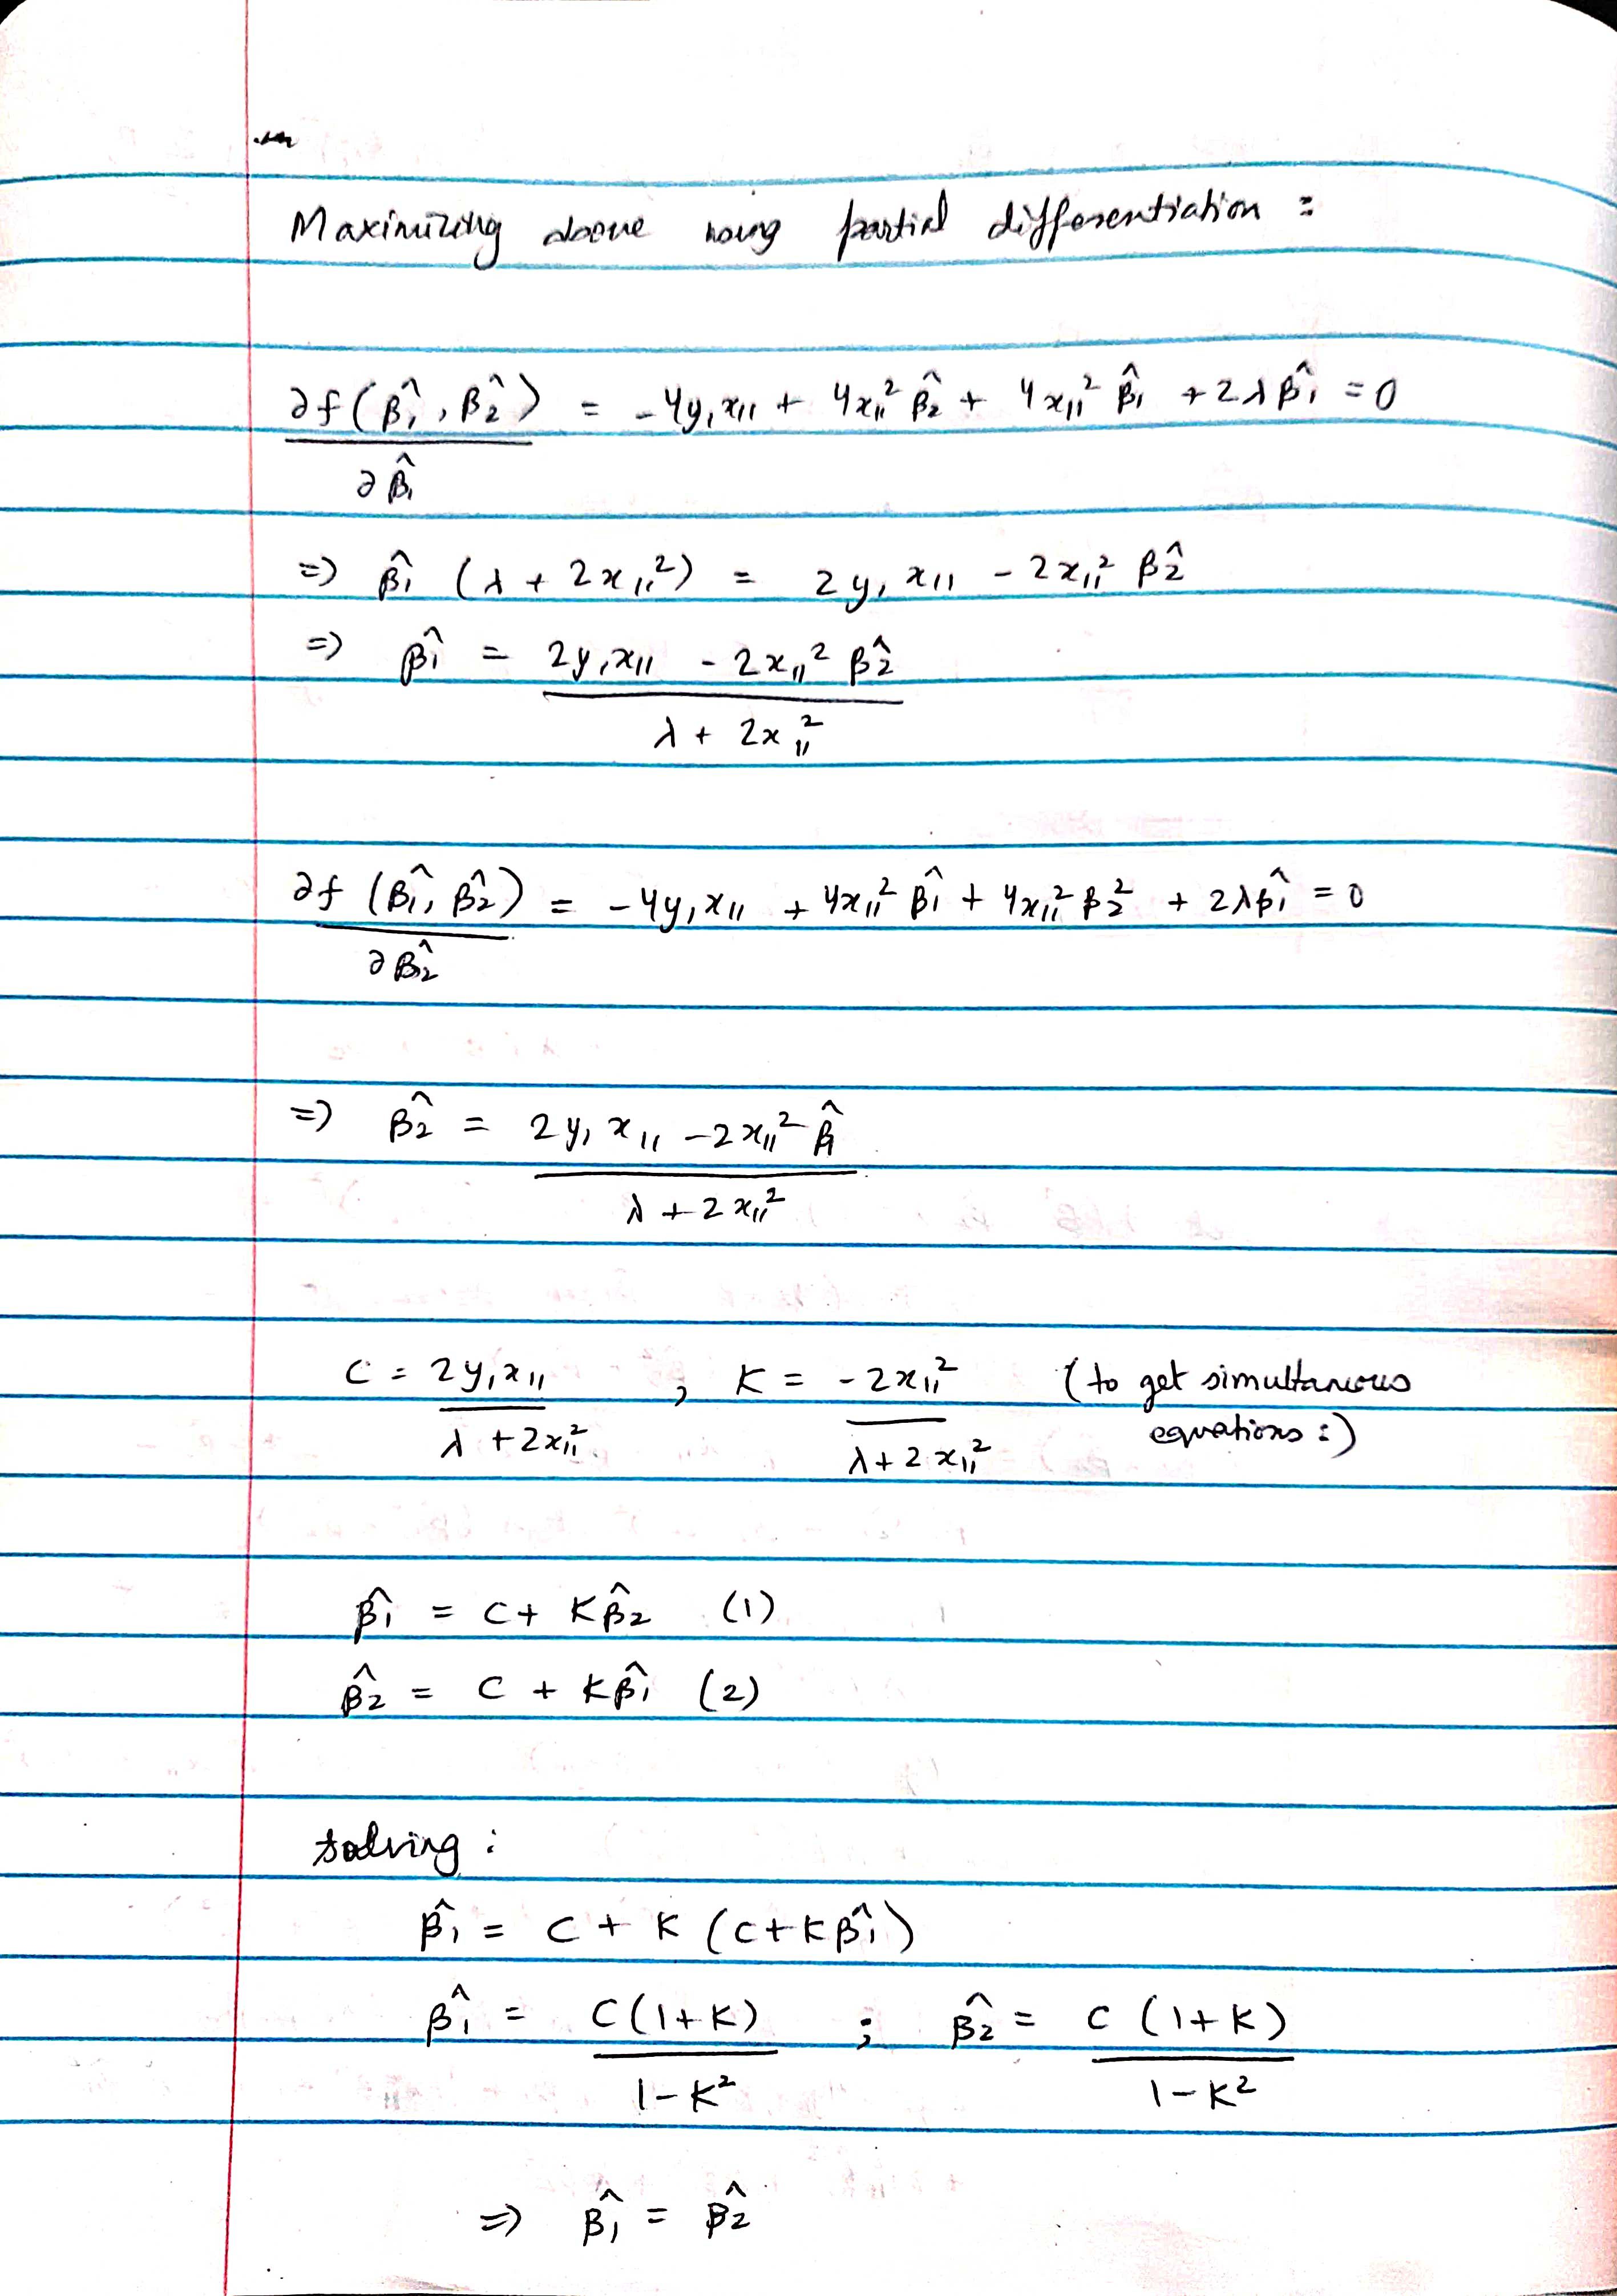

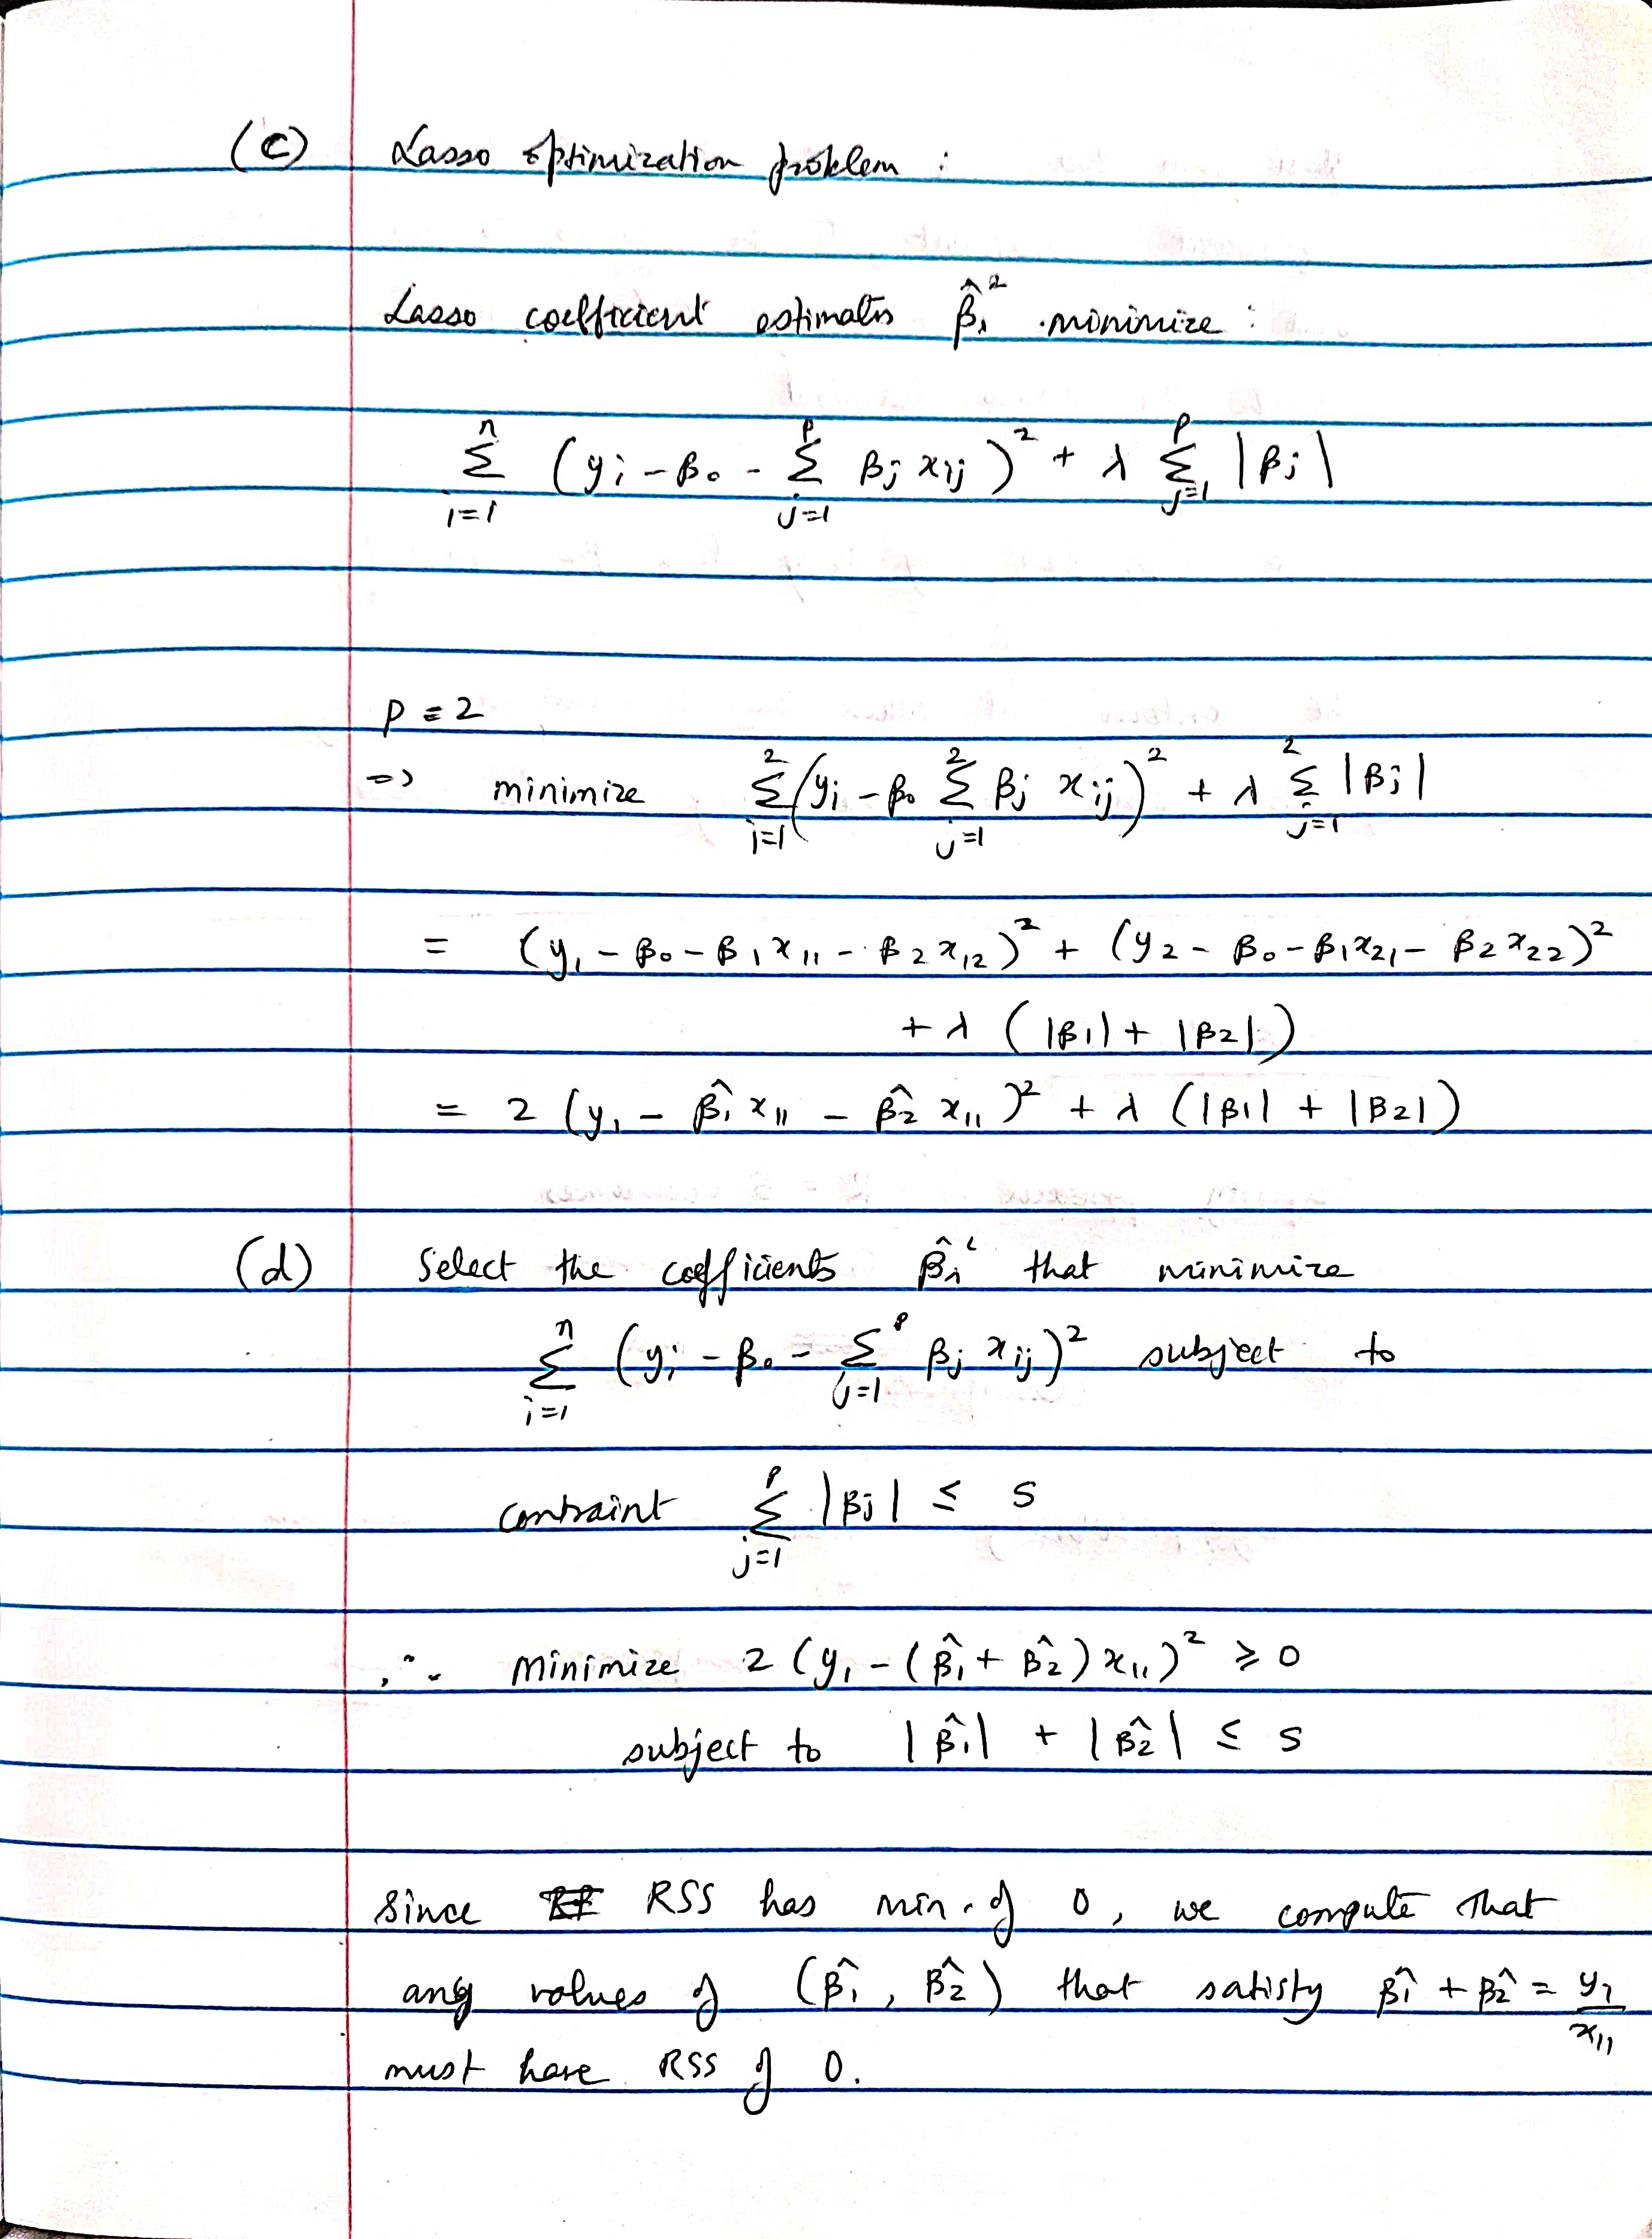

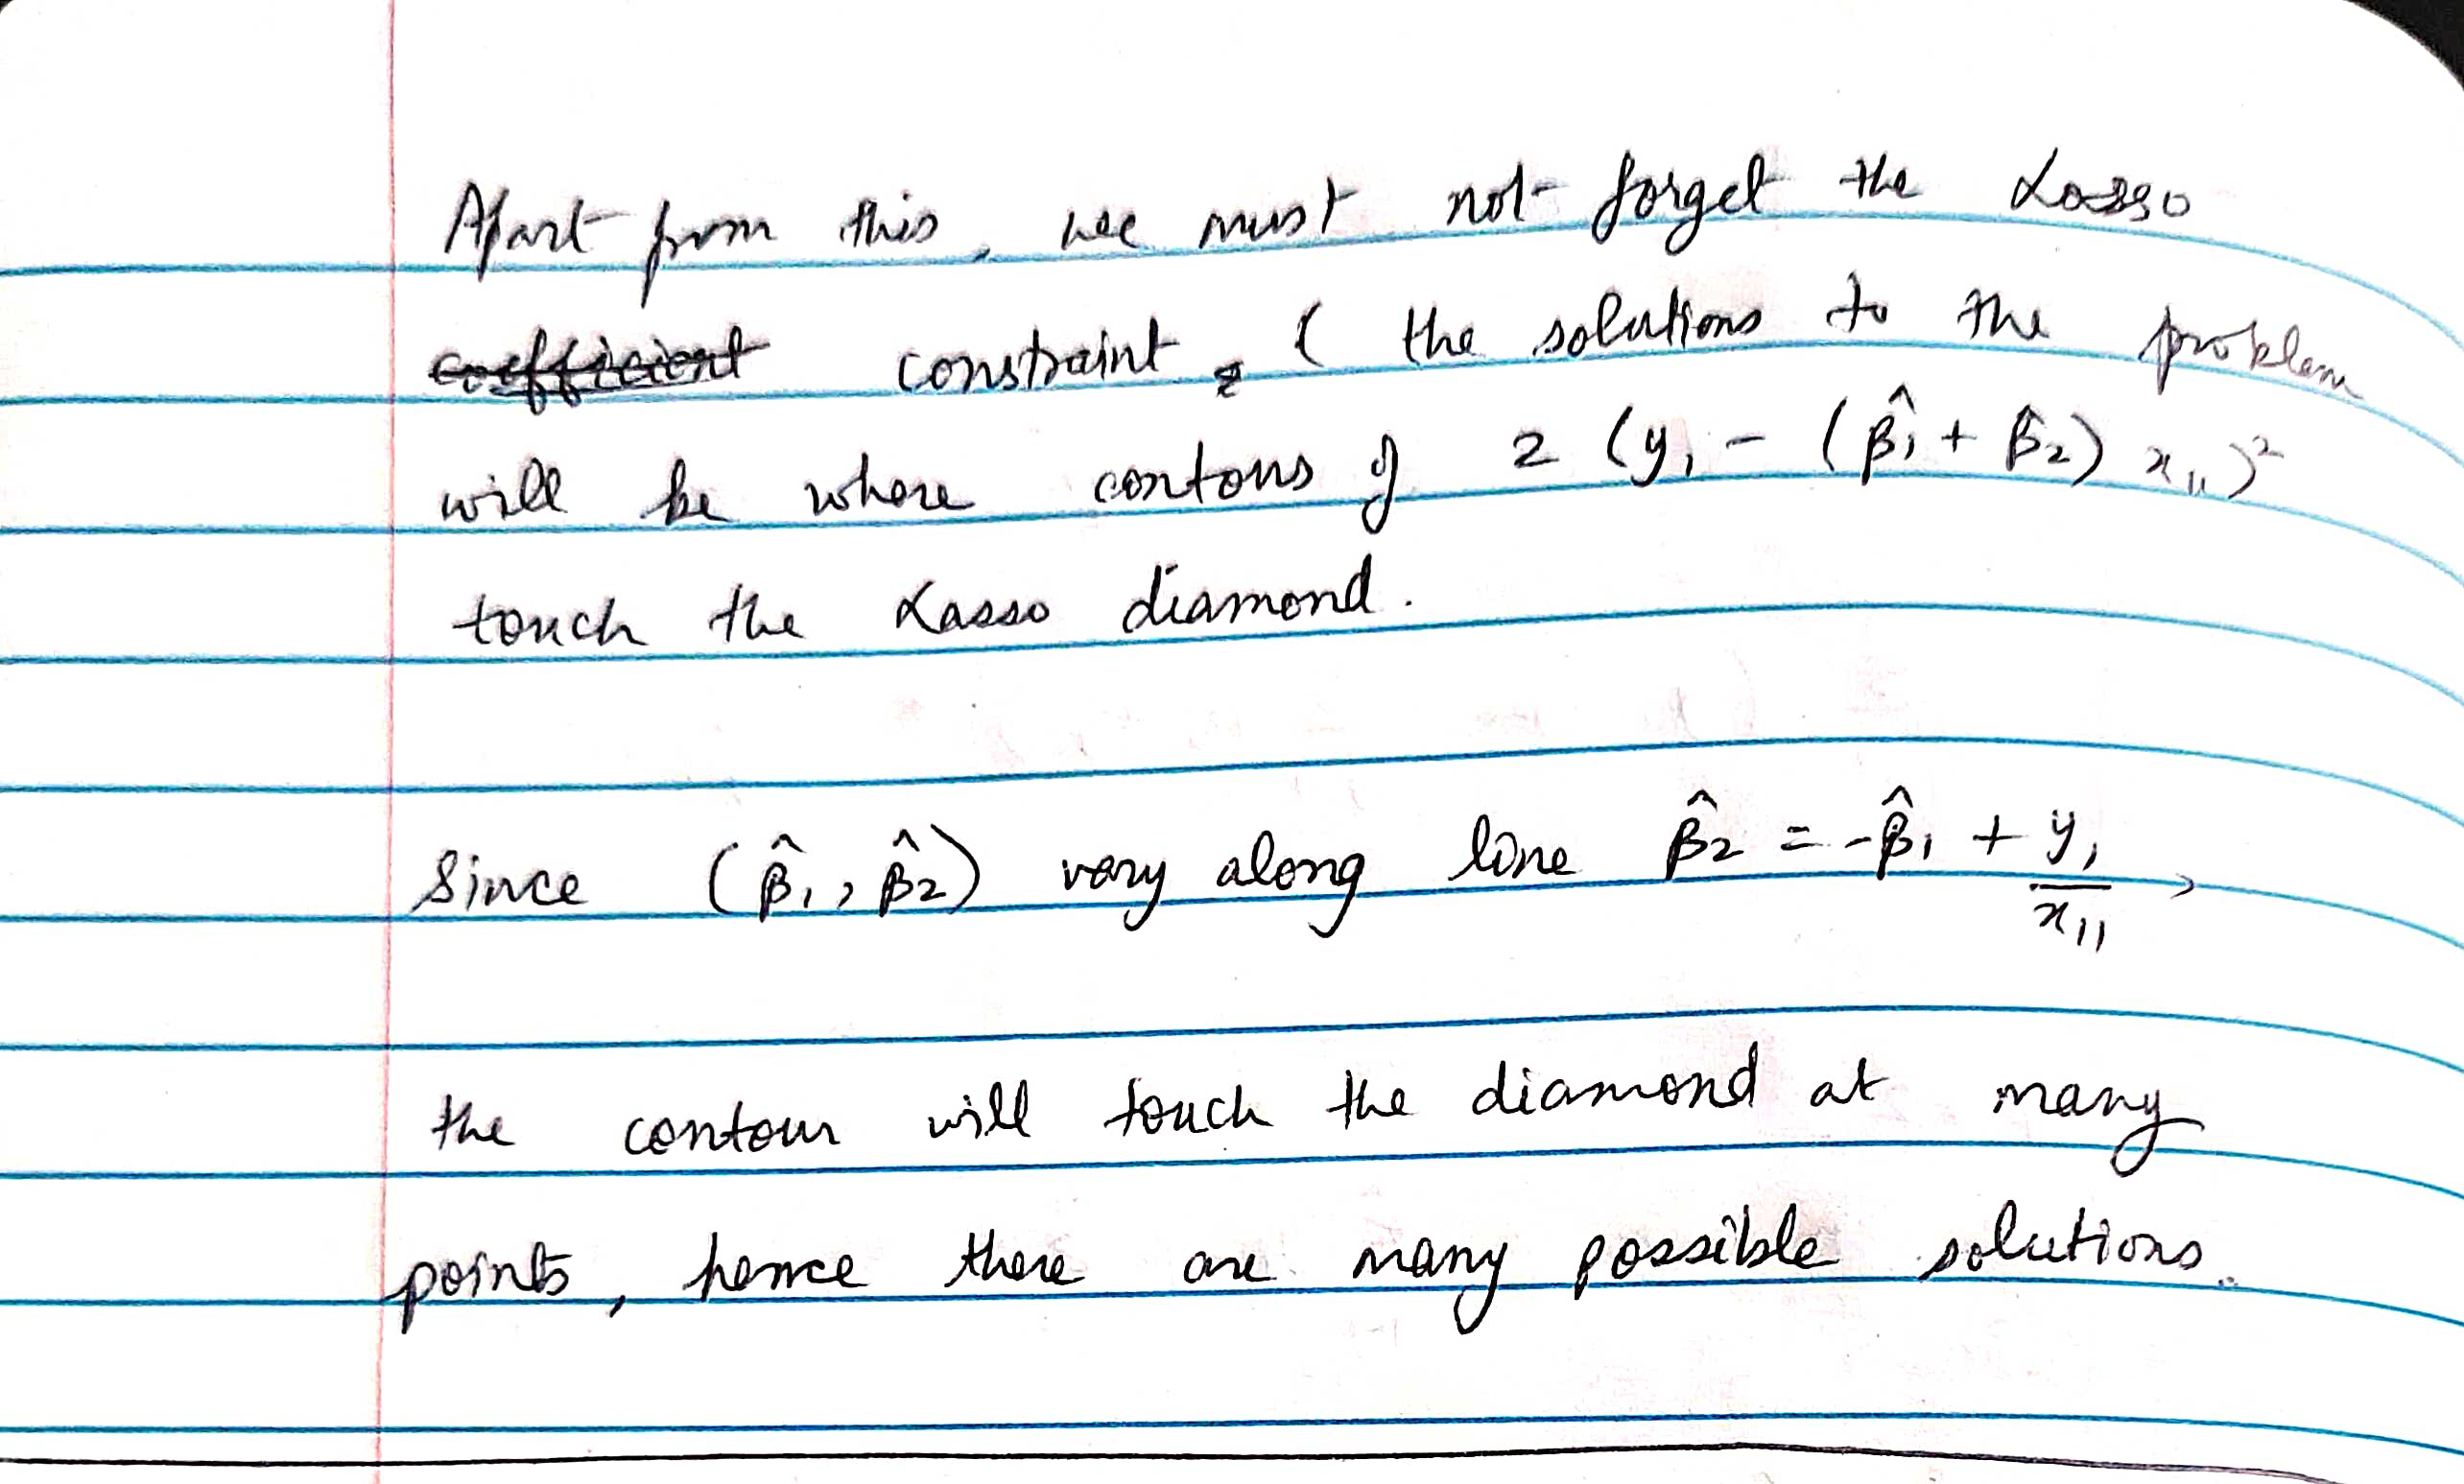

## 4. ISLR 8.4.5

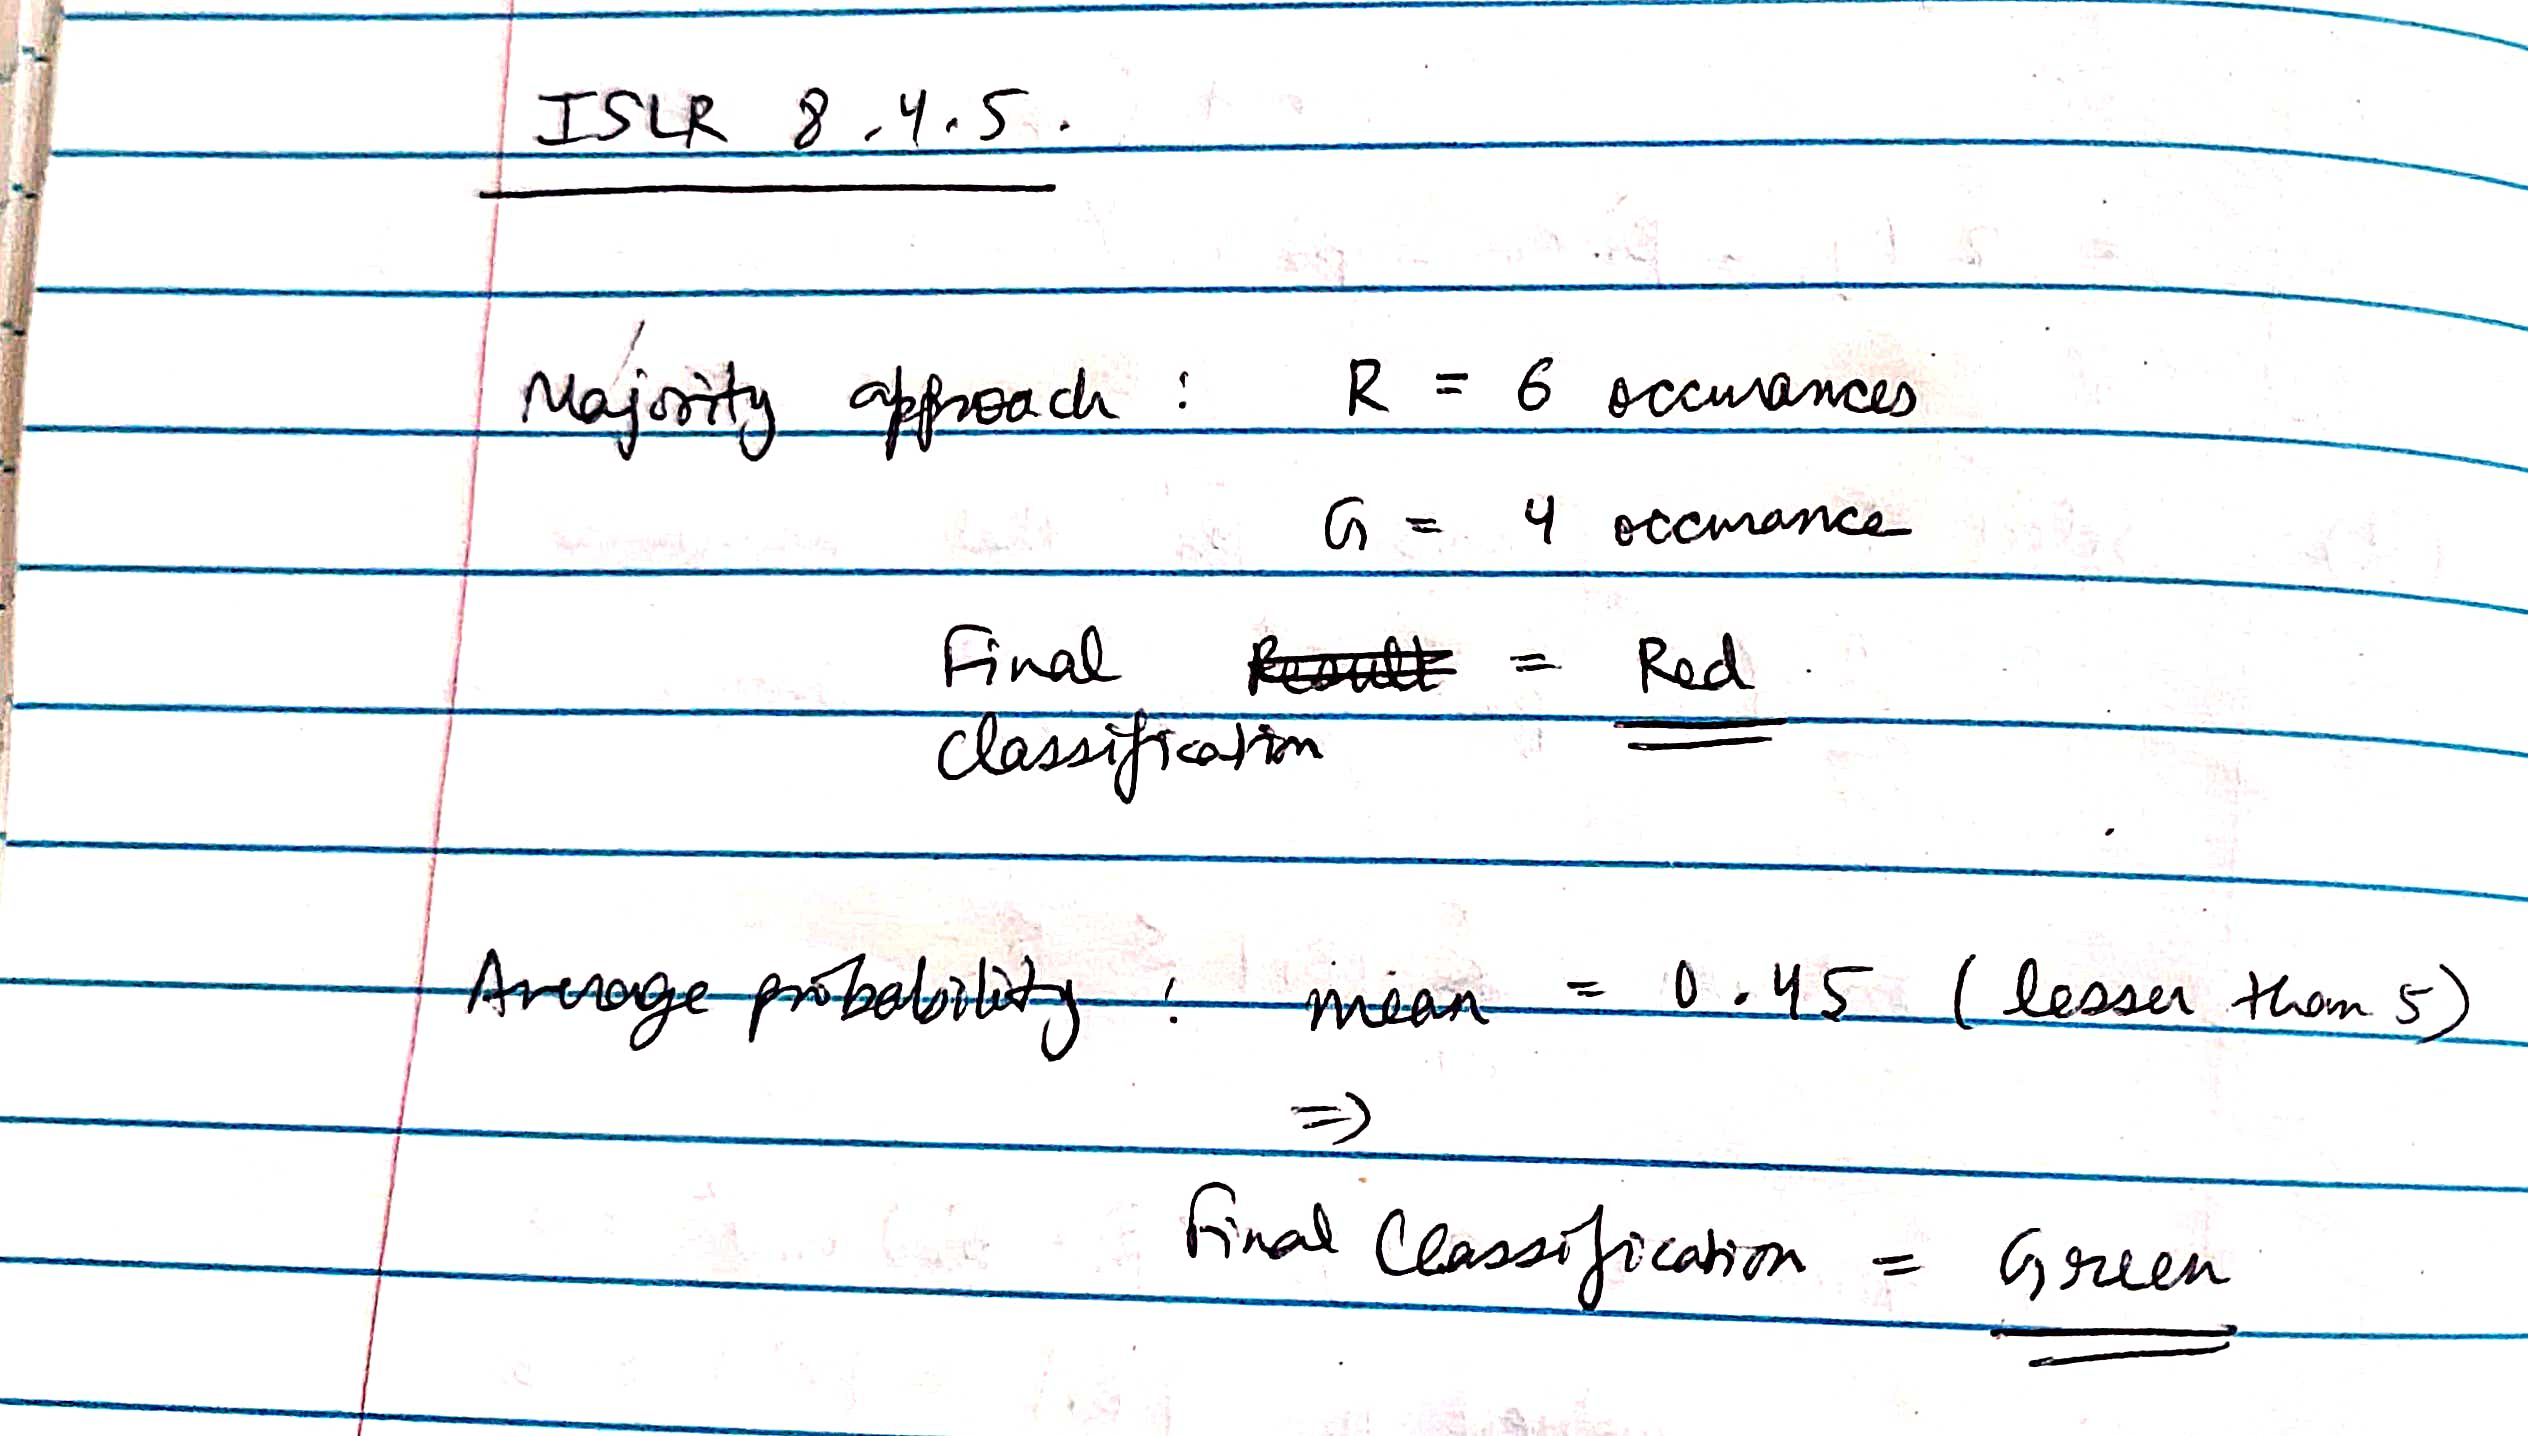

## 5. ISLR 9.7.3

### (a)

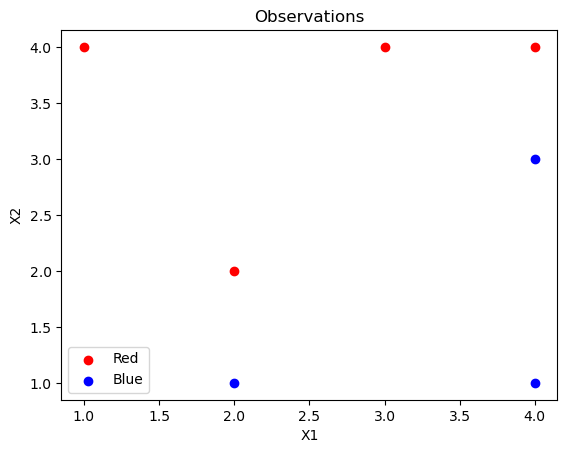

In [44]:
observations = {
    1: (3, 4, 'Red'),
    2: (2, 2, 'Red'),
    3: (4, 4, 'Red'),
    4: (1, 4, 'Red'),
    5: (2, 1, 'Blue'),
    6: (4, 3, 'Blue'),
    7: (4, 1, 'Blue')
}

def separate_observations(observations):
    x_red, y_red, x_blue, y_blue = [], [], [], []
    for obs, (x, y, label) in observations.items():
        if label == 'Red':
            x_red.append(x)
            y_red.append(y)
        else:
            x_blue.append(x)
            y_blue.append(y)
    return x_red, y_red, x_blue, y_blue

def plot_observations(x_red, y_red, x_blue, y_blue):
    plt.scatter(x_red, y_red, color='red', label='Red')
    plt.scatter(x_blue, y_blue, color='blue', label='Blue')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title('Observations')
    plt.legend()
    plt.show()

x_red, y_red, x_blue, y_blue = separate_observations(observations)
plot_observations(x_red, y_red, x_blue, y_blue)

### (b)

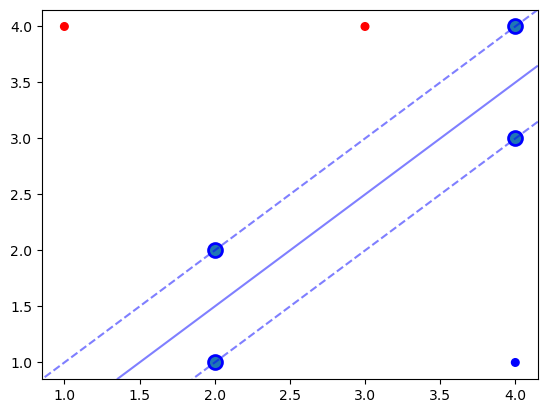

In [45]:
def create_dataframe(x1, x2, y):
    svm_data = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})
    return svm_data

def plot_svm_decision_boundary(X, y, model):
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=30)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    YY, XX = np.meshgrid(np.linspace(ylim[0], ylim[1], 30), np.linspace(xlim[0], xlim[1], 30))
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    decision_values = model.decision_function(xy).reshape(XX.shape)
    
    ax.contour(XX, YY, decision_values, colors="blue", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"])
    ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100, linewidth=2, edgecolors="blue")
    plt.show()

x1 = [3, 2, 4, 1, 2, 4, 4]
x2 = [4, 2, 4, 4, 1, 3, 1]
y = ['Red', 'Red', 'Red', 'Red', 'Blue', 'Blue', 'Blue']

svm_data = create_dataframe(x1, x2, y)

X, y = svm_data.drop('y', axis=1).values, svm_data['y']
svm_model = svm.SVC(kernel="linear", C=1000).fit(X, y)
plot_svm_decision_boundary(X, y, svm_model)


As seen above, the optimal separating hyperplane.
Equation: X1 = X2 + 0.5

### (c) 

- Classify to Red if X2 - X1 + 0.5 > 0
- Classify to Blue otherwise

### (d)
- Margin for maximal margin hyperplane: the solid blue line

### (e)
- Support vectors: the 4 points lying on the dashed lines:
- (2,1), (2,2), (4,3), (4,4)

### (f)
- The 7th observation's (4,1) slight movement would not affect the maximal margin hyperplane since it is not a support vector.

### (g)

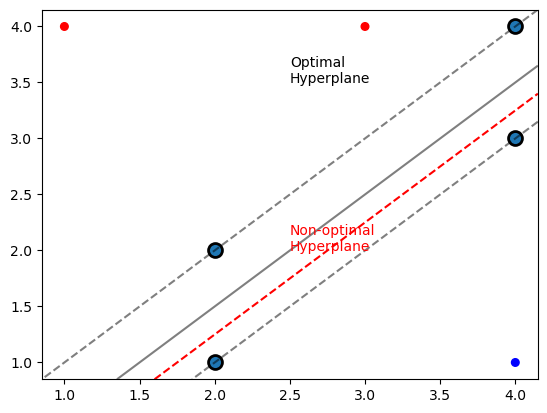

In [46]:
def create_dataframe(x1, x2, y):
    svm_data = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})
    return svm_data

def plot_svm_decision_boundary(X, y, model):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    YY, XX = np.meshgrid(np.linspace(ylim[0], ylim[1], 30), np.linspace(xlim[0], xlim[1], 30))
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    
    decision_values = model.decision_function(xy).reshape(XX.shape)
    ax.contour(XX, YY, decision_values, colors="black", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"])
    ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100, linewidth=2, edgecolors="black")
    ax.text(2.5, 3.5, 'Optimal\nHyperplane', color='black')
    
    ax.axline((2, 1.25), (3.5, 2.75), color='red', linestyle='--')
    ax.text(2.5, 2, 'Non-optimal\nHyperplane', color='red')
    
    plt.show()

x1 = [3, 2, 4, 1, 2, 4, 4]
x2 = [4, 2, 4, 4, 1, 3, 1]
y = ['Red', 'Red', 'Red', 'Red', 'Blue', 'Blue', 'Blue']

svm_data = create_dataframe(x1, x2, y)

X, y = svm_data.drop('y', axis=1).values, svm_data['y']
svm_model = svm.SVC(kernel="linear", C=1000).fit(X, y)
plot_svm_decision_boundary(X, y, svm_model)


(g) Non-optimal hyperplane shown above.
Equation: X1−X2−0.75=0

### (h)

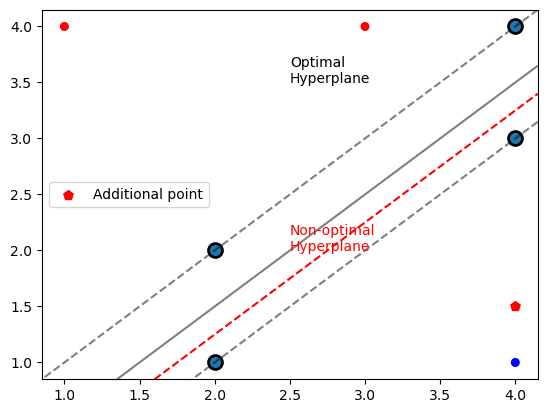

In [47]:
def create_dataframe(x1, x2, y):
    svm_data = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})
    return svm_data

def plot_svm_decision_boundary(X, y, model):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    YY, XX = np.meshgrid(np.linspace(ylim[0], ylim[1], 30), np.linspace(xlim[0], xlim[1], 30))
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    
    decision_values = model.decision_function(xy).reshape(XX.shape)
    ax.contour(XX, YY, decision_values, colors="black", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"])
    ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100, linewidth=2, edgecolors="black")
    ax.text(2.5, 3.5, 'Optimal\nHyperplane', color='black')
    
    ax.axline((2, 1.25), (3.5, 2.75), color='red', linestyle='--')
    ax.text(2.5, 2, 'Non-optimal\nHyperplane', color='red')
    ax.scatter([4.0], [1.5], color='red', marker='p', s=50, label="Additional point")
    ax.legend()

    plt.show()

x1 = [3, 2, 4, 1, 2, 4, 4]
x2 = [4, 2, 4, 4, 1, 3, 1]
y = ['Red', 'Red', 'Red', 'Red', 'Blue', 'Blue', 'Blue']

svm_data = create_dataframe(x1, x2, y)

X, y = svm_data.drop('y', axis=1).values, svm_data['y']
svm_model = svm.SVC(kernel="linear", C=1000).fit(X, y)
plot_svm_decision_boundary(X, y, svm_model)

In [10]:
!pip freeze > ../requirements.txt